# Analyzing the Recovery of the Canadian Economy Post COVID-19

In [1]:
from IPython.display import Image
Image(url='https://unsplash.com/photos/-ca8YHMKxFU/download?ixid=M3wxMjA3fDB8MXxhbGx8fHx8fHx8fHwxNjg5OTgwOTgyfA&force=true&w=1920')

## Objectives
This data analysis project provides a comprehensive exploration of the Canadian economy's recovery following the COVID-19 pandemic, from the initial impact in Q2 2020 through to Q2 2023. Utilizing an extensive dataset that encompasses a variety of industries, the analysis investigates the fluctuating economic health of each sector, highlighting areas of growth and decline.

Key areas of focus include the identification of industries that experienced the best and worst growth rates between Q2 2019 and Q2 2023. The study further compares these figures to performance metrics during the first wave of the pandemic in Q2 2020, providing a nuanced understanding of industry resilience and adaptability in the face of unprecedented challenges.

Furthermore, the project provides insights into the recovery journey of the industries that were most profoundly affected during the initial stages of the pandemic. Through an in-depth investigation of these sectors, this project seeks to evaluate whether they have been able to regain their footing and adapt to the 'new normal' precipitated by the COVID-19 crisis.

This portfolio project offers valuable insights for individuals looking to understand the economic ramifications of the COVID-19 pandemic, providing a thorough and detailed analysis of recovery trends across the diverse landscape of Canadian industries.

## Required libraries

Let's start by importing the required libraries for this project:

1. numpy
2. pandas
3. scipy
4. statsmodels
5. matplotlib
6. seaborn
7. plotly

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from statsmodels.sandbox.stats.multicomp import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

%config InlineBackend.figure_format = 'retina'

## Importing and cleaning a GDP dataset

📈 We will be using the GDP by industry dataset from Statistics Canada released on 2023-06-30: 
https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=3610043402

In [3]:
gdp = pd.read_csv('../data/36100434_gdp_by_industry_monthly.csv', usecols = ['REF_DATE', 'GEO', 'Seasonal adjustment', 'Prices', 'North American Industry Classification System (NAICS)', 'VALUE'])

🧐 We chose the following columns from this dataset:

**1. REF_DATE:** The month in which the data was collected;

**2. GEO:** The geographic region of the data. We are only interested in country-wide measurements (Canada);

**3. Seasonal adjustment:** The type of adjusment. Either "Seasonally adjusted at annual rates" or "Trading-day adjusted";

**4. North American Industry Classification System (NAICS):** The industry name and NAICS code from which the value was obtained from;

**5. VALUE:** The GDP measure in Canadian dollars (x1,000,000).

In [4]:
gdp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272076 entries, 0 to 272075
Data columns (total 6 columns):
 #   Column                                                 Non-Null Count   Dtype  
---  ------                                                 --------------   -----  
 0   REF_DATE                                               272076 non-null  object 
 1   GEO                                                    272076 non-null  object 
 2   Seasonal adjustment                                    272076 non-null  object 
 3   Prices                                                 272076 non-null  object 
 4   North American Industry Classification System (NAICS)  272076 non-null  object 
 5   VALUE                                                  237396 non-null  float64
dtypes: float64(1), object(5)
memory usage: 12.5+ MB


👉 We can optimize our dataset by changing the REF_DATE datatype to date/time and GEO, Seasonal adjustment, Prices, NAICS to category.

In [5]:
gdp['REF_DATE'] = pd.to_datetime(gdp['REF_DATE'])
gdp = gdp.astype({'GEO' : 'category',
          'Seasonal adjustment' : 'category',
          'Prices' : 'category', 
          'North American Industry Classification System (NAICS)': 'category'})

In [6]:
gdp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272076 entries, 0 to 272075
Data columns (total 6 columns):
 #   Column                                                 Non-Null Count   Dtype         
---  ------                                                 --------------   -----         
 0   REF_DATE                                               272076 non-null  datetime64[ns]
 1   GEO                                                    272076 non-null  category      
 2   Seasonal adjustment                                    272076 non-null  category      
 3   Prices                                                 272076 non-null  category      
 4   North American Industry Classification System (NAICS)  272076 non-null  category      
 5   VALUE                                                  237396 non-null  float64       
dtypes: category(4), datetime64[ns](1), float64(1)
memory usage: 5.5 MB


👉 We are mostly interested in long-term trends and thus we will use Seasonally adjusted prices constant prices (in millions of dollars)

In [7]:
gdp = gdp.query('`Seasonal adjustment` == "Seasonally adjusted at annual rates" and Prices == "2012 constant prices"').copy()

In [8]:
gdp

REF_DATE     GEO                  Seasonal adjustment   
287    1997-01-01  Canada  Seasonally adjusted at annual rates  \
288    1997-01-01  Canada  Seasonally adjusted at annual rates   
289    1997-01-01  Canada  Seasonally adjusted at annual rates   
290    1997-01-01  Canada  Seasonally adjusted at annual rates   
291    1997-01-01  Canada  Seasonally adjusted at annual rates   
...           ...     ...                                  ...   
271784 2023-04-01  Canada  Seasonally adjusted at annual rates   
271785 2023-04-01  Canada  Seasonally adjusted at annual rates   
271786 2023-04-01  Canada  Seasonally adjusted at annual rates   
271787 2023-04-01  Canada  Seasonally adjusted at annual rates   
271788 2023-04-01  Canada  Seasonally adjusted at annual rates   

                      Prices   
287     2012 constant prices  \
288     2012 constant prices   
289     2012 constant prices   
290     2012 constant prices   
291     2012 constant prices   
...                      ...   
271784  2012 constant prices   
271785  2012 constant prices   
271786  2012 constant prices   
271787  2012 constant prices   
271788  2012 constant prices   

       North American Industry Classification System (NAICS)      VALUE  
287                                 All industries [T001]     1161269.0  
288                     Goods-producing industries [T002]      402792.0  
289                   Service-producing industries [T003]      756654.0  
290                     Business sector industries [T004]           NaN  
291                         Business sector, goods [T005]           NaN  
...                                                   ...           ...  
271784                            Defence services [9111]       12660.0  
271785  Federal government public administration (exce...       43931.0  
271786  Provincial and territorial public administrati...       37278.0  
271787  Local, municipal and regional public administr...       46027.0  
271788             Aboriginal public administration [914]        5230.0  

[90692 rows x 6 columns]

✅ Let's also rename a couple of columns to make our life easier:
1. 'REF_DATE' will become 'date';
2. 'North American Industry Classification System (NAICS)' will become 'industry';
3. 'VALUE' will become 'value'.

In [9]:
gdp = gdp.rename(columns = {'REF_DATE' : 'date',
                          'North American Industry Classification System (NAICS)': 'industry',
                          'VALUE' : 'value'}).set_index('date')[['industry', 'value']].copy()
gdp

industry      value
date                                                                    
1997-01-01                              All industries [T001]  1161269.0
1997-01-01                  Goods-producing industries [T002]   402792.0
1997-01-01                Service-producing industries [T003]   756654.0
1997-01-01                  Business sector industries [T004]        NaN
1997-01-01                      Business sector, goods [T005]        NaN
...                                                       ...        ...
2023-04-01                            Defence services [9111]    12660.0
2023-04-01  Federal government public administration (exce...    43931.0
2023-04-01  Provincial and territorial public administrati...    37278.0
2023-04-01  Local, municipal and regional public administr...    46027.0
2023-04-01             Aboriginal public administration [914]     5230.0

[90692 rows x 2 columns]

👉 Let's separate the industry code from the industry name and assign it to a new column named 'industry_code'.

In [10]:
new_df = gdp['industry'].str.split('[', expand=True)
gdp['industry'] = new_df[0].str.strip()
gdp['industry_code'] = new_df[1].str.replace(']', '').str.strip()
gdp = gdp[['industry', 'industry_code', 'value']]
gdp

industry industry_code   
date                                                                          
1997-01-01                                     All industries          T001  \
1997-01-01                         Goods-producing industries          T002   
1997-01-01                       Service-producing industries          T003   
1997-01-01                         Business sector industries          T004   
1997-01-01                             Business sector, goods          T005   
...                                                       ...           ...   
2023-04-01                                   Defence services          9111   
2023-04-01  Federal government public administration (exce...          911A   
2023-04-01   Provincial and territorial public administration           912   
2023-04-01  Local, municipal and regional public administr...           913   
2023-04-01                   Aboriginal public administration           914   

                value  
date                   
1997-01-01  1161269.0  
1997-01-01   402792.0  
1997-01-01   756654.0  
1997-01-01        NaN  
1997-01-01        NaN  
...               ...  
2023-04-01    12660.0  
2023-04-01    43931.0  
2023-04-01    37278.0  
2023-04-01    46027.0  
2023-04-01     5230.0  

[90692 rows x 3 columns]

‼️ Cannabis has been legalized in Canada in 2018 and thus will skew these results. Let's remove them from the analysis!

In [11]:
gdp = gdp[~gdp['industry'].str.contains('|'.join(['Cannabis', 'cannabis']))].copy()

👉 Great, we can start taking a look at some insights from this dataset. 

💰 Let's use seaborn to plot the overall growth of the Canadian economy across all industries.

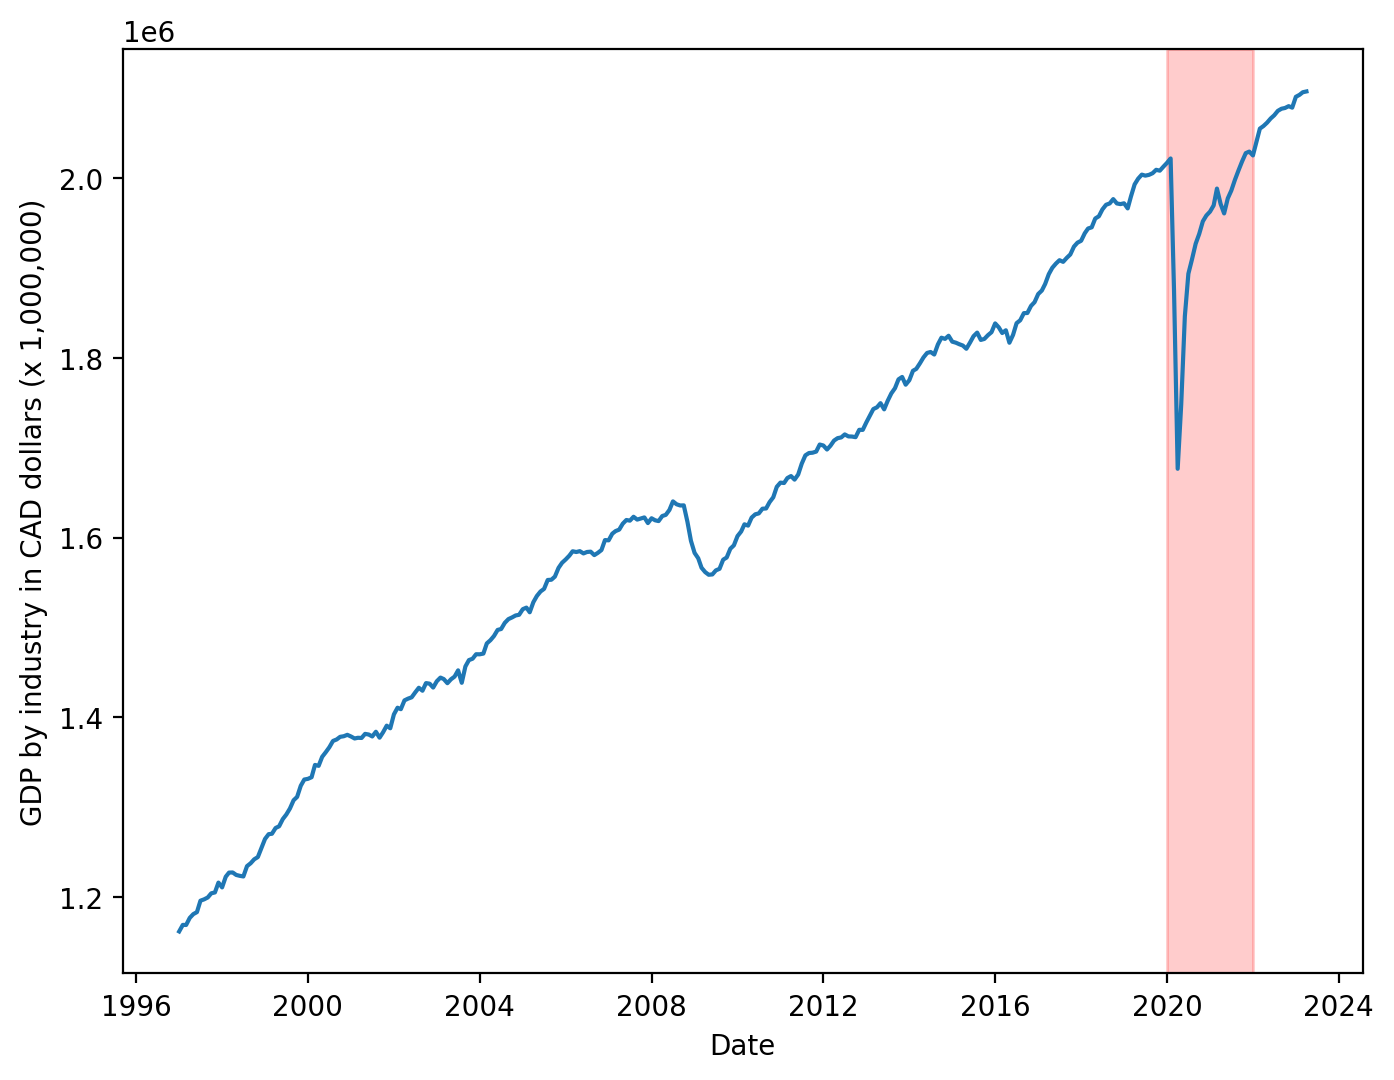

In [12]:
# Create a line plot using Seaborn
plt.figure(figsize=(8, 6))
sns.lineplot(data = gdp.query('industry == "All industries"'), x = 'date', y = 'value')

# Highlight a section using axvspan() or axhspan()
plt.axvspan('2020-01-01', '2022-01-01', color='red', alpha=0.2)

# Set labels and title
plt.xlabel('Date')
plt.ylabel('GDP by industry in CAD dollars (x 1,000,000)')

# Show the plot
plt.show()

☝️ We can clearly observe the impact of the COVID-19 pandemic on the Canadian economy in the chart above. 

🧐 It does seem that the overall economy has somewhat recovered since 2020, but is this true for all industries? Let's take a look!

👉 Let's first aggregate our data by quarterly periods:

In [13]:
gdp_grouped = gdp.groupby([gdp.index.to_period('Q'), 'industry', 'industry_code']).median()
gdp_grouped

value
date   industry                                           industry_code          
1997Q1 Aboriginal public administration                   914                 NaN
       Accommodation and food services                    72              28186.0
       Accommodation services                             721              9371.0
       Accounting, tax preparation, bookkeeping and pa... 5412                NaN
       Activities related to credit intermediation        5223                NaN
...                                                                           ...
2023Q2 Water, sewage and other systems                    2213             3375.0
       Wholesale electronic markets, and agents and br... 419              3107.0
       Wholesale trade                                    41             106337.0
       Wineries and distilleries                          3121A            1099.0
       Wood product manufacturing                         321              9149.0

[28938 rows x 1 columns]

👌 Let's also specify the date range in which we will be analyzing our data. I chose **2019Q2** as the baseline for two reasons:

1. It controls for seasonality by looking at a year before the peak of the COVID-19 pandemic (2020Q2);
2. Our latest data is from 2023Q2, allowing us to have a full 4-year outlook at the economy.

In [14]:
date_range = ['2019Q2', '2023Q2']

👇 We will use a function to filter the dataset between the time ranges above and eliminate any time periods and industries with NA's:

In [15]:
def filter_datarange(df, date_range, index_columns, date_column, value_column):
    """
    This function will filter the dataset between specific time periods and eliminate any time periods and industries with NA's.
    It will then calculate the cumulative growth since the first period in the date_range

    Parameters
    ----------
    df : Panda's DataFrame
        DataFrame to apply function
    date_range : list or tupple
        Two elements, first and last periods to analyze
    index_columns : list or tupple
        Column names to create index from
    date_column : str
        Column name containing dates
    value_column: str
        Column name containing values
        
    Returns
    -------
    Panda's DataFrame
    """
    df = df.reset_index()
    df_pivot = df[(df[date_column] >= date_range[0]) & (df[date_column] <= date_range[1])].pivot(index = index_columns, columns = date_column, values = value_column).dropna(how = 'any')
    df_melt = df_pivot.reset_index().melt(id_vars = index_columns, var_name = date_column, value_name = value_column).set_index(date_column).sort_index()
    df_melt['cumulative_growth'] = df_melt.groupby(index_columns).transform(lambda x: (x - x.iloc[0]) / x.iloc[0] * 100)
    return df_melt

In [16]:
gdp_clean = filter_datarange(df = gdp_grouped, date_range = date_range, index_columns = ['industry', 'industry_code'], date_column = 'date', value_column = 'value')
gdp_clean

industry industry_code   
date                                                                      
2019Q2                   Aboriginal public administration           914  \
2019Q2                    Accommodation and food services            72   
2019Q2                             Accommodation services           721   
2019Q2  Accounting, tax preparation, bookkeeping and p...          5412   
2019Q2        Activities related to credit intermediation          5223   
...                                                   ...           ...   
2023Q2                    Water, sewage and other systems          2213   
2023Q2  Wholesale electronic markets, and agents and b...           419   
2023Q2                                    Wholesale trade            41   
2023Q2                          Wineries and distilleries         3121A   
2023Q2                         Wood product manufacturing           321   

           value  cumulative_growth  
date                                 
2019Q2    4517.0           0.000000  
2019Q2   43887.0           0.000000  
2019Q2   13599.0           0.000000  
2019Q2   12954.0           0.000000  
2019Q2    3187.0           0.000000  
...          ...                ...  
2023Q2    3375.0           3.147922  
2023Q2    3107.0           2.541254  
2023Q2  106337.0           1.487908  
2023Q2    1099.0          15.320042  
2023Q2    9149.0           2.820859  

[4641 rows x 4 columns]

Great, this dataset is now ready to be analyzed!

## How has the COVID-19 pandemic affected each Canadian industry?

### What are the 10 industries with the highest GDP gain since 2019Q2?

👇 Let's create a function to visualize the cumulative growth of specific industries using plotly:

In [17]:
def plot_line_graph(df, industry_codes, y_col, title, y_axis_title):
    """
    This function will plot a line graph based on the list of industry codes provided and name it according to title.

    Parameters
    ----------
    df : Panda's DataFrame
        DataFrame to plot data from
    industry_codes : list or tupple
        List of industry codes to filter df
    y_col: str
        Column to take the y-axis values from
    title : str
        Plot title
        
    Returns
    -------
    plotly plot
    """
    industry_codes = industry_codes
    df.index = df.index.astype('str')
    fig = px.line(df.query('industry_code in @industry_codes'), y=y_col, color='industry', markers=True, color_discrete_sequence=px.colors.qualitative.Dark24, template='plotly_white')
    # Modify the layout to change the axis labels
    fig.update_layout(
        autosize=True,
        title_text=title,
        xaxis_title='Year',  # Set the x-axis label
        yaxis_title=' '.join([y_axis_title, 'since', date_range[0]]),
        shapes=[
        dict(
            type='line',
            xref='x',
            yref='y',
            x0=date_range[0],
            y0=0,
            x1=date_range[1],
            y1=0,
            line=dict(
                color='black',
                width=2,
                dash='dash'
            )
        )
    ]
    )
    fig.show()

🧐 Now let's filter our dataset to find out which industries had the highest cumulative growth since 2019Q2.

In [18]:
best_industries_gdp = gdp_clean.xs(date_range[1]).nlargest(n = 10, columns = 'cumulative_growth')
best_industries_gdp_list = best_industries_gdp['industry_code'].tolist()
best_industries_gdp

industry industry_code   
date                                                                      
2023Q2     Data processing, hosting, and related services           518  \
2023Q2                                Non-store retailers           454   
2023Q2                              Tobacco manufacturing          3122   
2023Q2       Computer systems design and related services          5415   
2023Q2    Computer and peripheral equipment manufacturing          3341   
2023Q2                 Industrial machinery manufacturing          3332   
2023Q2  Engine, turbine and power transmission equipme...          3336   
2023Q2                            Warehousing and storage           493   
2023Q2  Pesticide, fertilizer and other agricultural c...          3253   
2023Q2  Ventilation, heating, air-conditioning and com...          3334   

          value  cumulative_growth  
date                                
2023Q2   6775.0          64.641555  
2023Q2   6290.0          50.514477  
2023Q2   1354.0          43.736730  
2023Q2  45908.0          37.944712  
2023Q2    259.0          35.602094  
2023Q2   2800.0          35.200386  
2023Q2    677.0          31.456311  
2023Q2   4998.0          28.351310  
2023Q2   2915.0          28.244611  
2023Q2   2453.0          26.248070

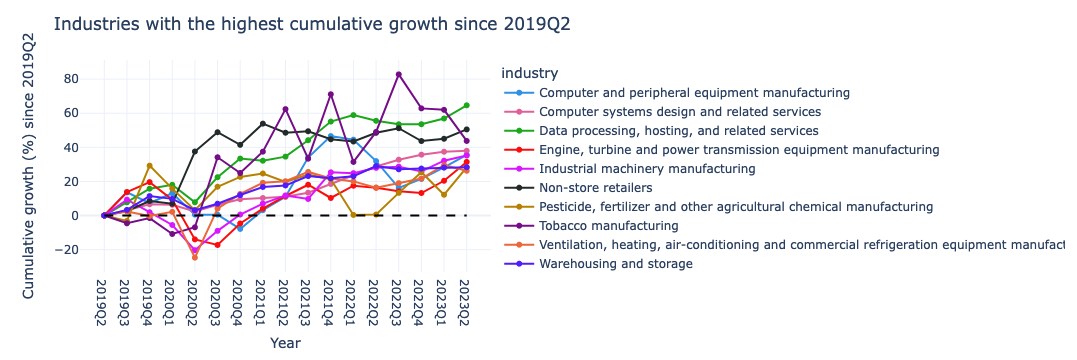

In [19]:
plot_line_graph(df = gdp_clean, industry_codes = best_industries_gdp_list, y_col = 'cumulative_growth', title = ''.join(['Industries with the highest cumulative growth since ', date_range[0]]), y_axis_title = 'Cumulative growth (%)')

🧐 It looks like **"Data processing, hosting, and related services"** has been the industry with the highest growth in Canada since 2019Q2!

👇 In fact, we can visualize how massive this growth has been when compared to the industry average below:

In [20]:
def plot_line_industries(df, industry_names):
    """
    This function will plot a line graph based on the list of industry names provided.

    Parameters
    ----------
    df : Panda's DataFrame
        DataFrame to plot data from
    industry_names : list or tupple
        List of industry names to filter df
        
    Returns
    -------
    seaborn plot
    """
    sns.relplot(data = df.query('industry in @industry_names'), x = 'date', y = 'cumulative_growth', hue = 'industry', kind = 'line', height=6, aspect=1.25)
    plt.xticks(df.index[gdp_clean.index.str.contains('Q2')].unique().to_list())

    # Set labels and title
    plt.xlabel('Date')
    plt.ylabel('Cumulative growth (%) since '+date_range[0])

    #Set threshold
    plt.axhline(0, color='black', linestyle='--')

    # Show the plot
    plt.show()
        

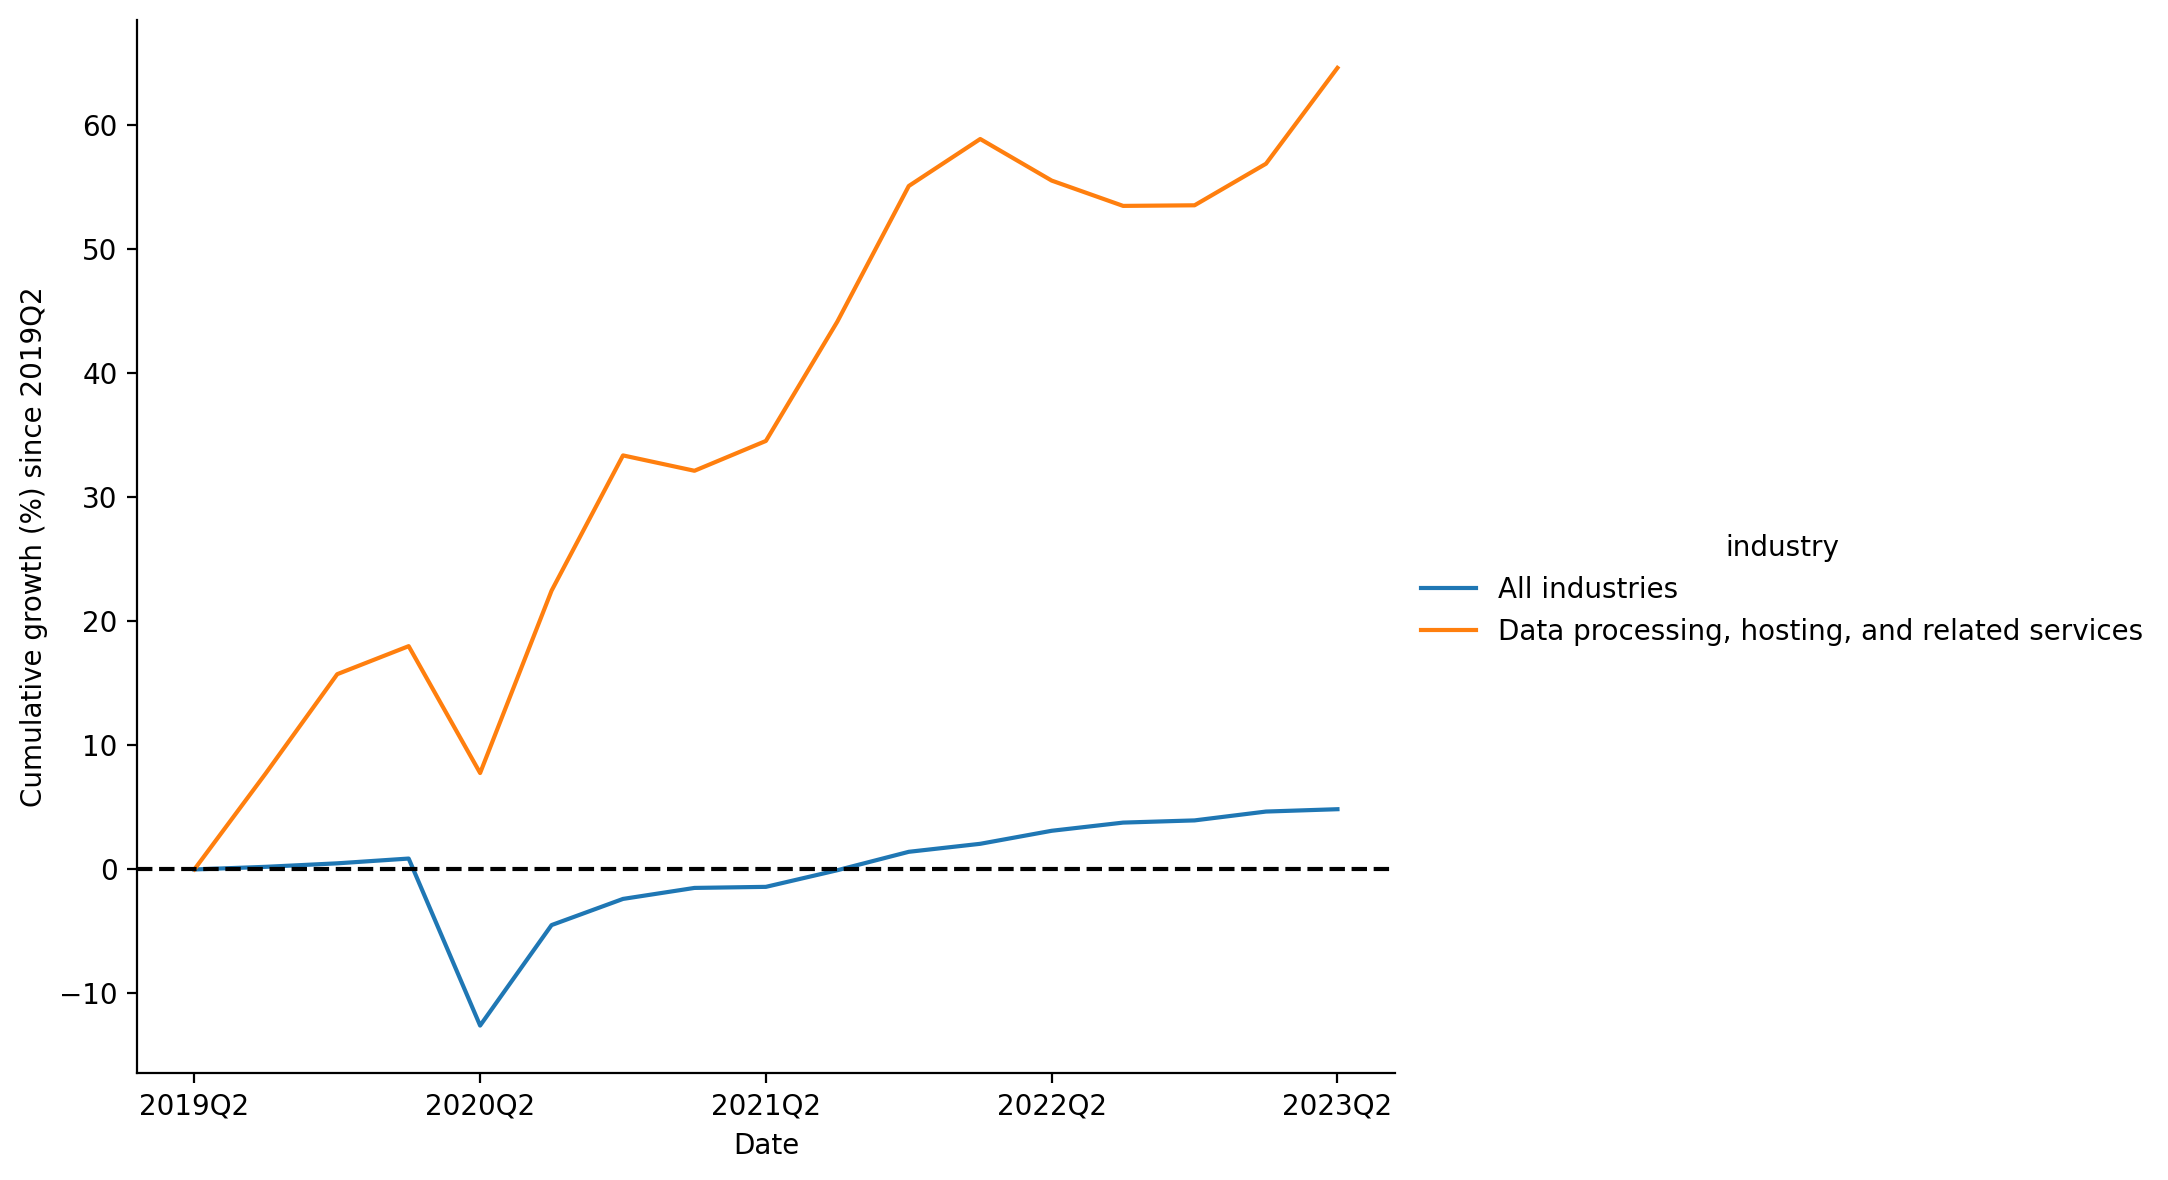

In [21]:
plot_line_industries(df = gdp_clean, industry_names = ["All industries", "Data processing, hosting, and related services"])

### What are the 10 industries with the lowest GDP gain since 2019Q2?

👉 Let's repeat the analysis and look at the industries with the lowest growth since 2019Q2:

In [22]:
worst_industries_gdp = gdp_clean.xs(date_range[1]).nsmallest(n = 10, columns = 'cumulative_growth')
worst_industries_gdp_list = worst_industries_gdp['industry_code'].tolist()
worst_industries_gdp

industry industry_code   
date                                                                      
2023Q2            Management of companies and enterprises            55  \
2023Q2  Other non-metallic mineral mining and quarryin...        21239X   
2023Q2  Non-ferrous metal (except aluminum) production...          3314   
2023Q2          Electric lighting equipment manufacturing          3351   
2023Q2            Automotive equipment rental and leasing          5321   
2023Q2            Printing and related support activities           323   
2023Q2           Copper, nickel, lead and zinc ore mining         21223   
2023Q2      Other furniture-related product manufacturing          3379   
2023Q2                        Motor vehicle manufacturing          3361   
2023Q2                             Hardware manufacturing          3325   

         value  cumulative_growth  
date                               
2023Q2  1504.0         -72.993356  
2023Q2  2071.0         -35.981453  
2023Q2  2232.0         -35.862069  
2023Q2   488.0         -32.782369  
2023Q2  2974.0         -31.221092  
2023Q2  3289.0         -31.134841  
2023Q2  4571.0         -29.892638  
2023Q2   258.0         -29.508197  
2023Q2  4961.0         -27.449547  
2023Q2   522.0         -27.094972

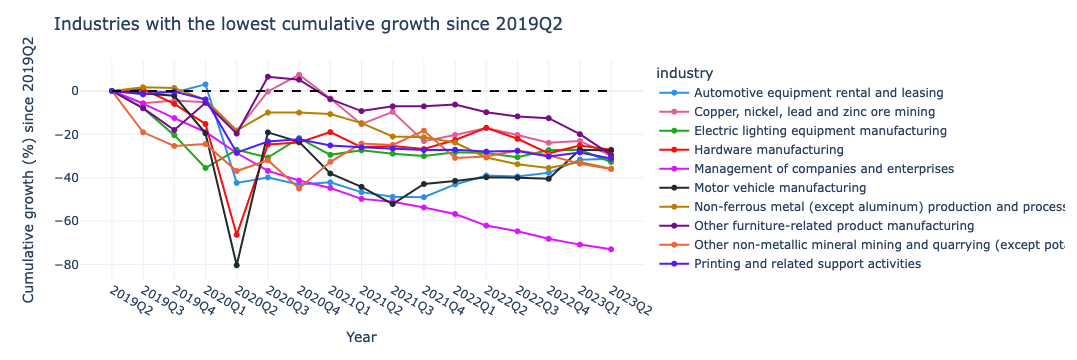

In [23]:
plot_line_graph(df = gdp_clean, industry_codes = worst_industries_gdp_list, y_col = 'cumulative_growth', title = ''.join(['Industries with the lowest cumulative growth since ', date_range[0]]), y_axis_title = 'Cumulative growth (%)')

🧐 It looks like **"Management of companies and enterprises"** has been the industry with the lowest growth in Canada since 2019Q2.

👇 In fact, this industry has been steadily declining since at least 2019Q2!

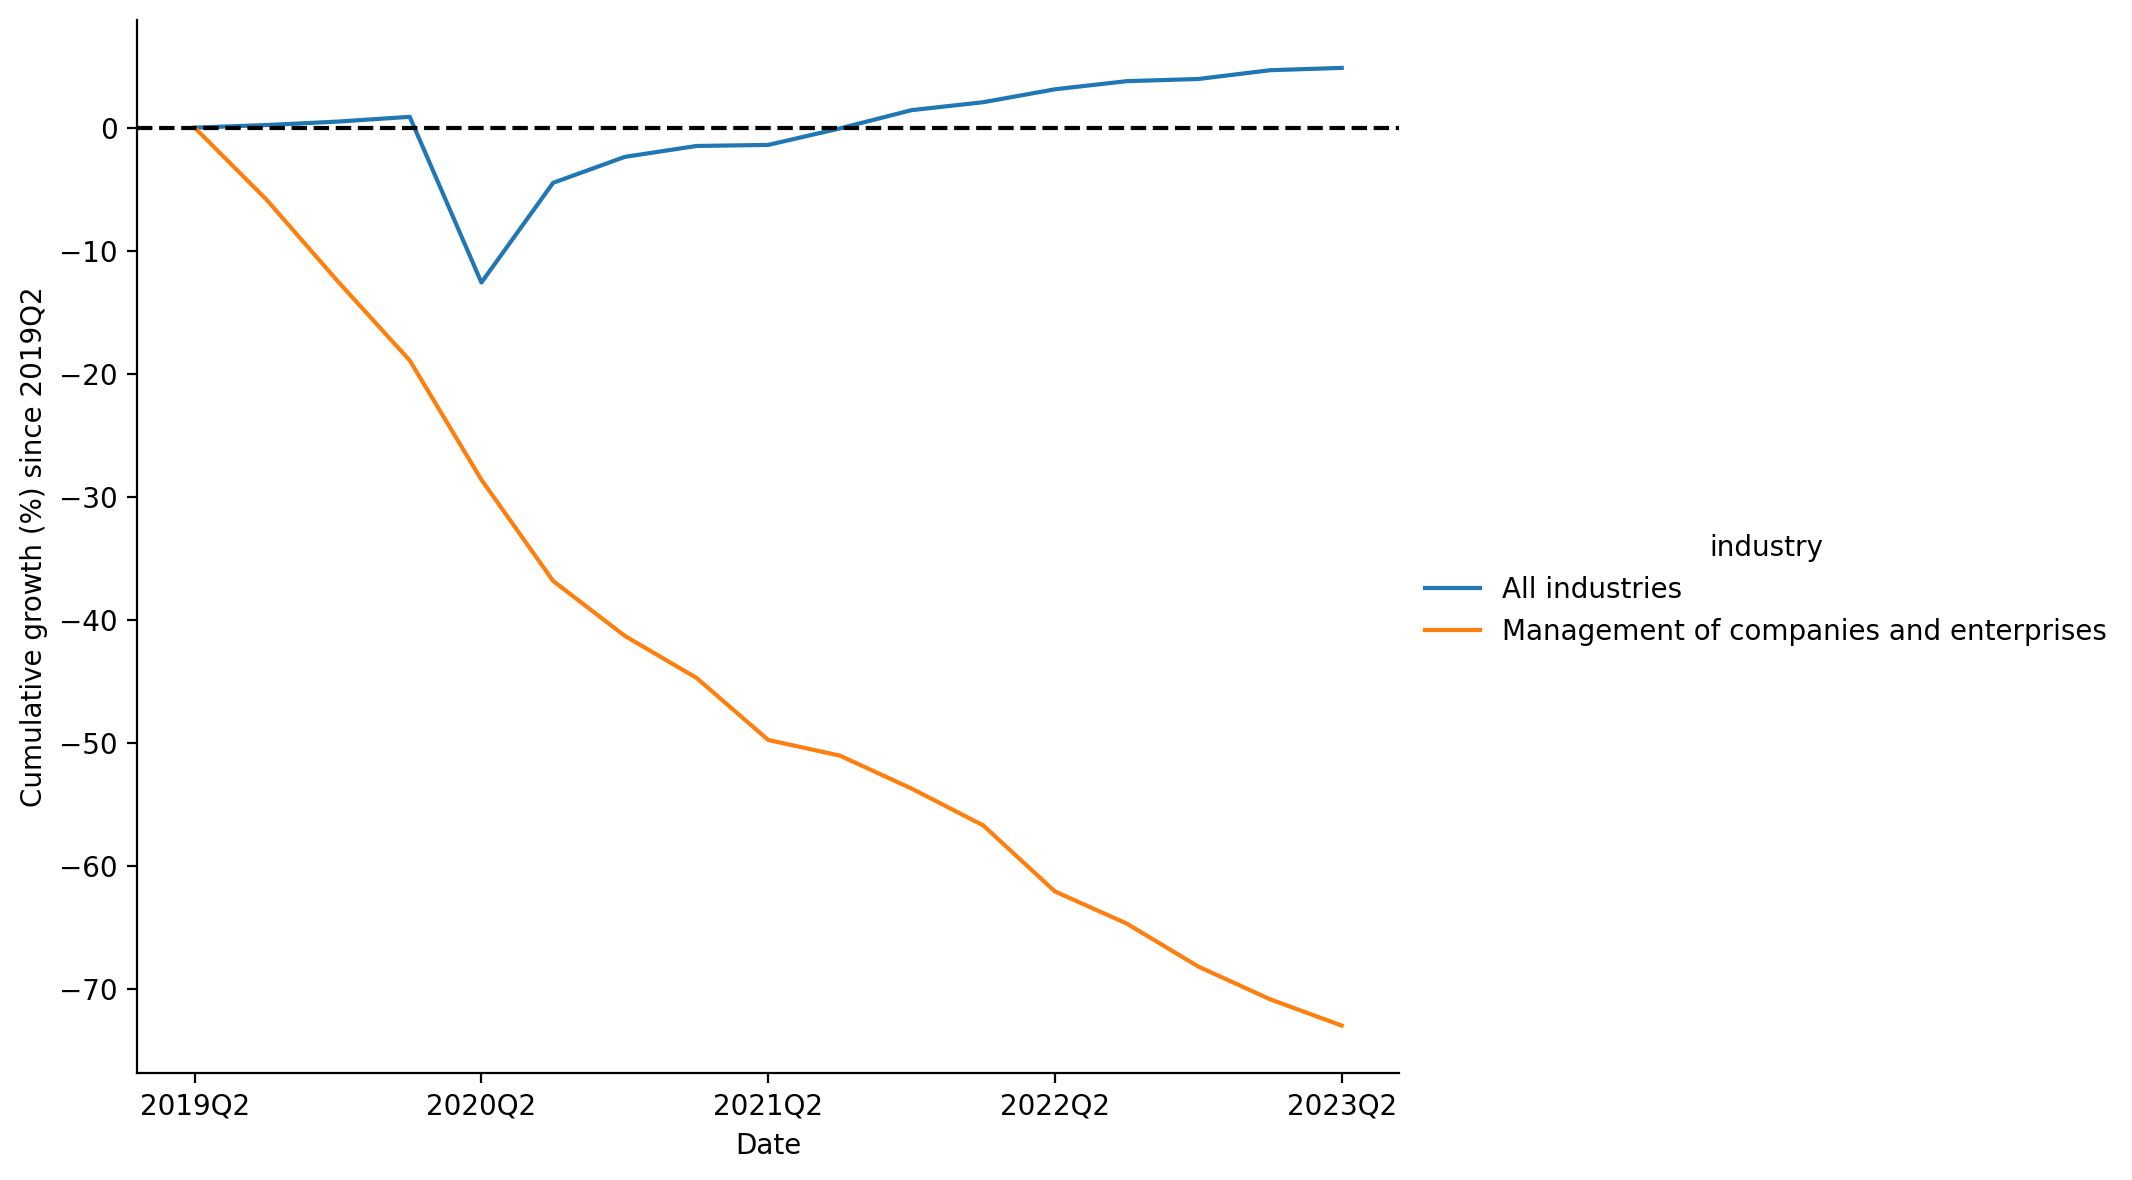

In [24]:
plot_line_industries(df = gdp_clean, industry_names = ["All industries", "Management of companies and enterprises"])

👇 Interestingly, if we look at historical data we can see that the "Data processing, hosting, and related services" industry started gaining a lot of momentum at a similar time when "Management of companies and enterprises" started to decline.

🧐 This may represent a shift in the Canadian economy to a more tech and data-focused around 2015.

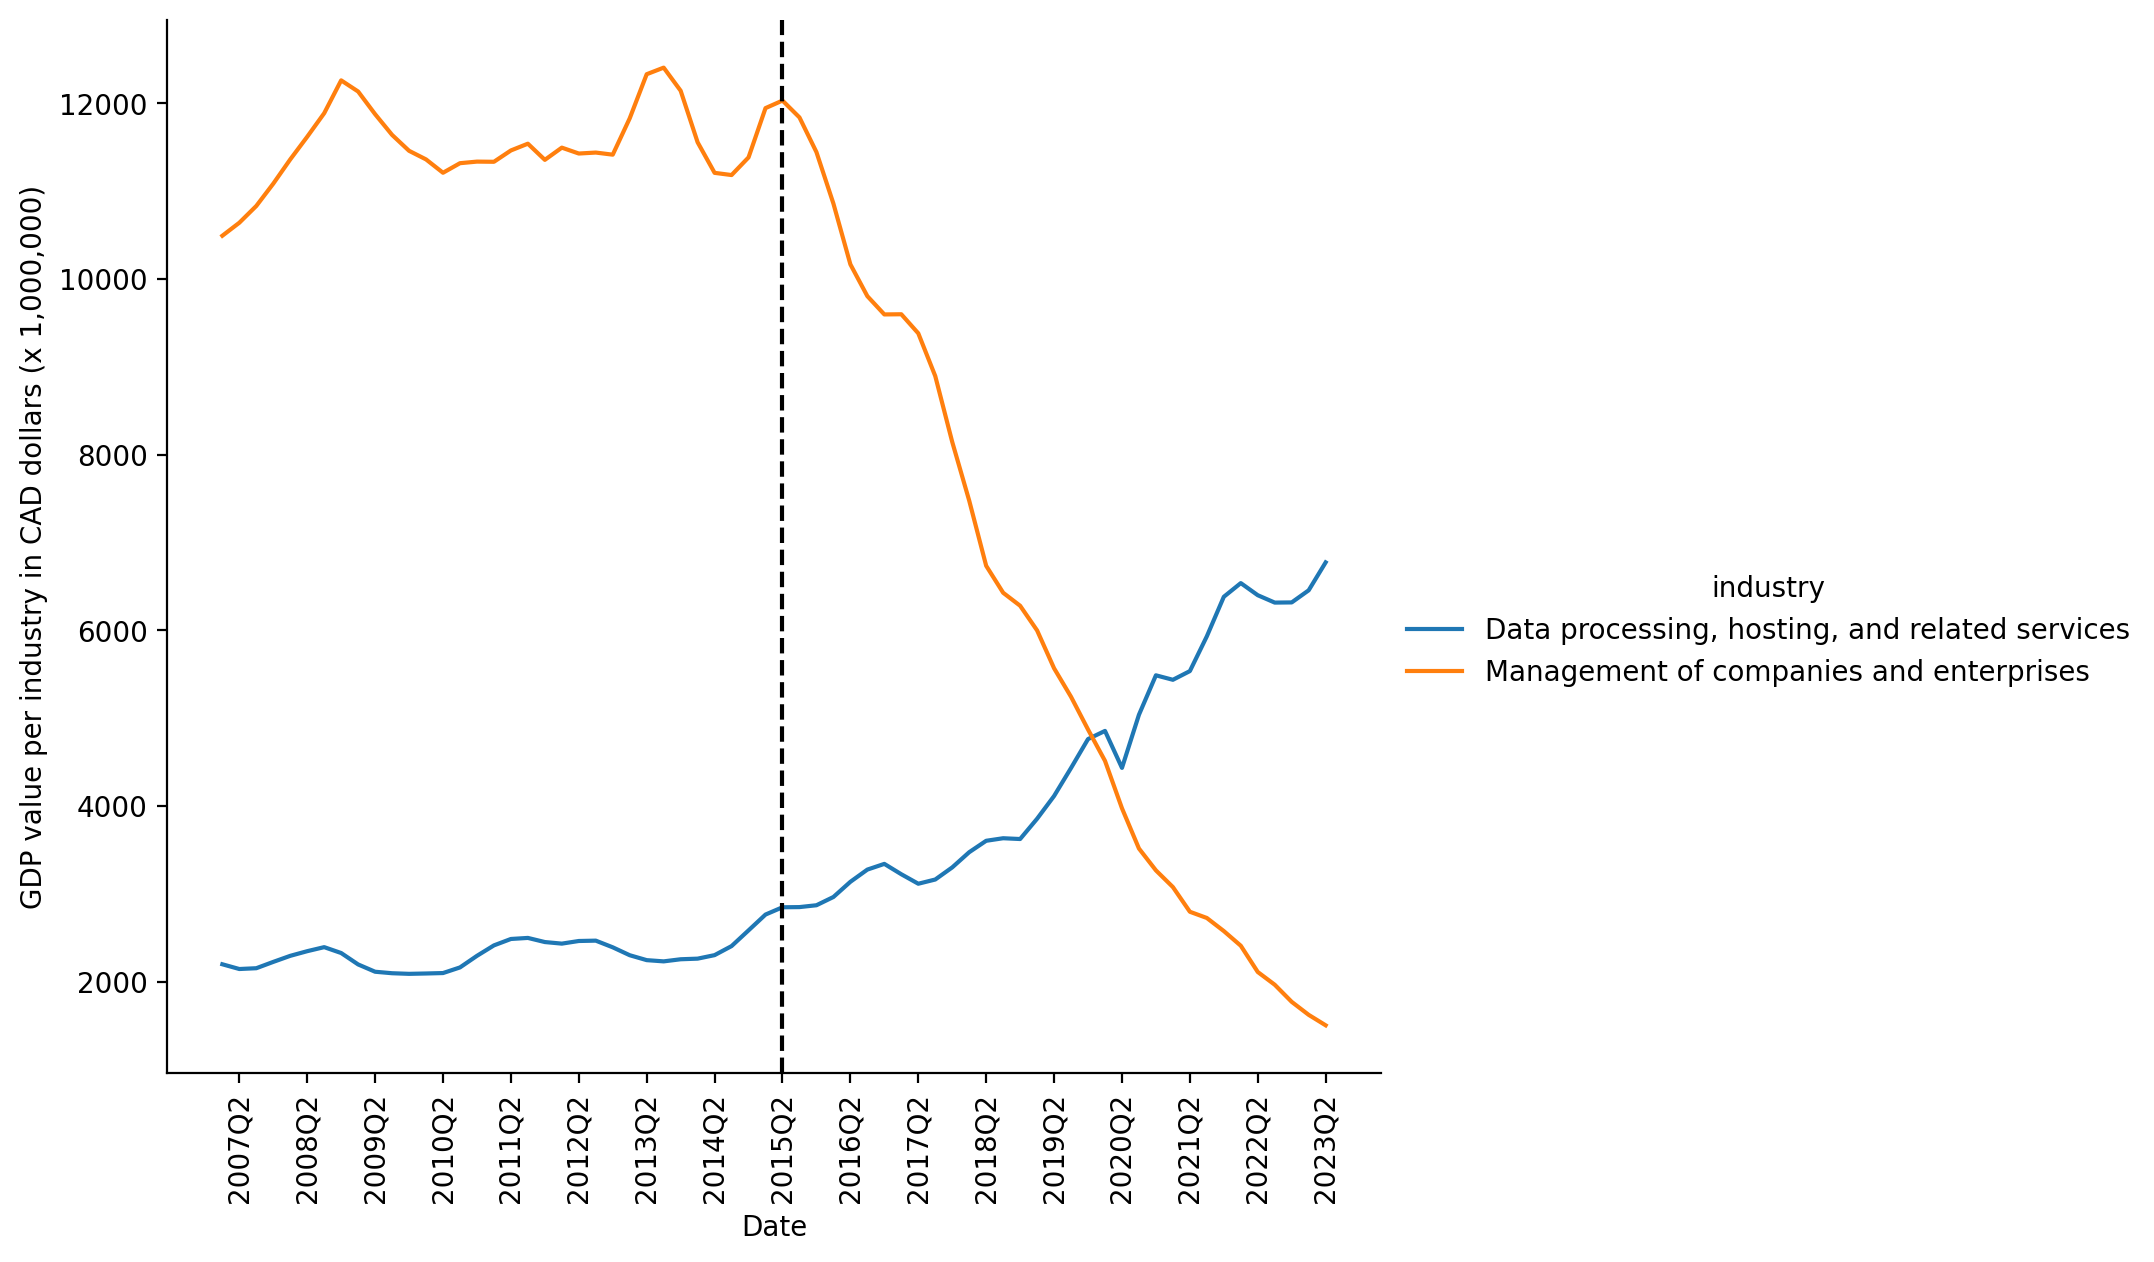

In [25]:
data_processing = gdp_grouped.xs('Data processing, hosting, and related services', level=1).dropna()
management = gdp_grouped.xs('Management of companies and enterprises', level = 1).dropna()
data_processing_management = pd.concat([data_processing, management], keys = ['Data processing, hosting, and related services', 'Management of companies and enterprises']).reset_index(names = ['industry', 'date', 'industry_code'])
data_processing_management['date'] = data_processing_management['date'].astype('str')
sns.relplot(data_processing_management, x = 'date', y = 'value', kind = 'line', hue = 'industry', height=6, aspect=1.25)
plt.xticks(data_processing_management[data_processing_management['date'].str.contains('Q2')]['date'].unique().tolist())
plt.xticks(rotation=90)
plt.axvline('2015Q2', color='black', linestyle='--')
# Set labels and title
plt.xlabel('Date')
plt.ylabel('GDP value per industry in CAD dollars (x 1,000,000)')
plt.show()

### What were the industries with the best and worst performance during the firts wave of the COVID-19 pandemic (2020Q2)?

👉 The COVID-19 pandemic hit the economy the hardest in 2020Q2. What were the industries that had the best and worst performance during this period of time?

📈 Let's create a function to visualize the types of industries most affected during the pandemic:

In [26]:
def plot_bar_plot(df, title, xaxis_title):
    """
    This function will plot a bar graph based on the dataframe provided.

    Parameters
    ----------
    df : Panda's DataFrame
        DataFrame to plot data from
    title : str
        Plot title
        
    Returns
    -------
    plotly plot
    """
    fig = px.bar(df, x = 'cumulative_growth', y = 'industry', color='industry', color_discrete_sequence=px.colors.qualitative.Dark24, template='plotly_white')
    fig.update_layout(
    autosize=True,
    showlegend=False,
    title_text=title,
    yaxis_title='Industry',  # Set the x-axis label
    xaxis_title=xaxis_title)
    fig.show()

In [27]:
best_industries_gdp_2020 = gdp_clean.xs('2020Q2').nlargest(n = 10, columns = 'cumulative_growth')
best_industries_gdp_2020

industry industry_code   
date                                                                      
2020Q2                                Non-store retailers           454  \
2020Q2                          Wineries and distilleries         3121A   
2020Q2              Converted paper product manufacturing          3222   
2020Q2                            Couriers and messengers           492   
2020Q2                                    Iron ore mining         21221   
2020Q2  Banking, monetary authorities and other deposi...          52BX   
2020Q2  Depository credit intermediation and monetary ...           52B   
2020Q2         Postal service and couriers and messengers           49A   
2020Q2     Data processing, hosting, and related services           518   
2020Q2                                    Crop production           111   

          value  cumulative_growth  
date                                
2020Q2   5748.0          37.544867  
2020Q2   1237.0          29.800630  
2020Q2   3200.0          12.478032  
2020Q2   3837.0          10.960093  
2020Q2   7541.0           9.084334  
2020Q2  71491.0           8.726598  
2020Q2  76358.0           8.387628  
2020Q2   7387.0           8.091893  
2020Q2   4435.0           7.776428  
2020Q2  30310.0           6.721594

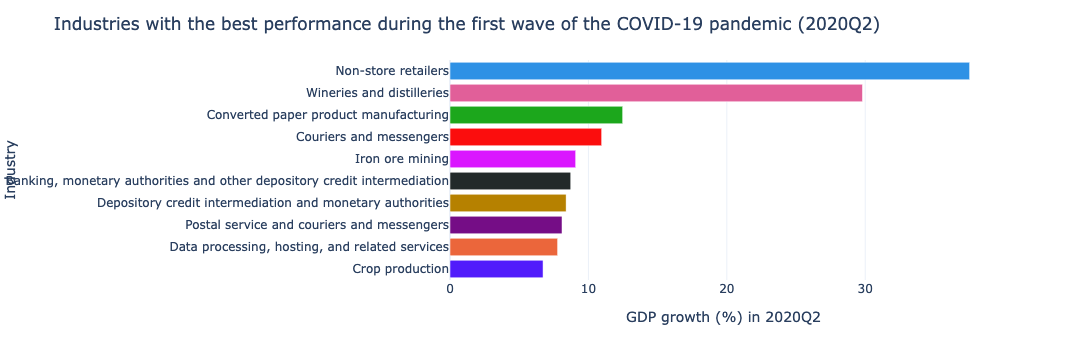

In [28]:
plot_bar_plot(df = best_industries_gdp_2020, title = 'Industries with the best performance during the first wave of the COVID-19 pandemic (2020Q2)', xaxis_title = 'GDP growth (%) in 2020Q2')

☝️ Not surprisingly, the best performing industry during the height of the COVID-19 pandemic was **"Non-store retailers"**, which include online shops.

In [29]:
worst_industries_gdp_2020 = gdp_clean.xs('2020Q2').nsmallest(n = 10, columns = 'cumulative_growth')
worst_industries_gdp_2020

industry industry_code   
date                                                                      
2020Q2                                 Air transportation           481  \
2020Q2                              Urban transit systems          4851   
2020Q2                        Motor vehicle manufacturing          3361   
2020Q2             Motor vehicles and parts manufacturing          336Y   
2020Q2                  Motor vehicle parts manufacturing          3363   
2020Q2                             Accommodation services           721   
2020Q2  Transit, ground passenger, scenic and sightsee...           48Z   
2020Q2                             Hardware manufacturing          3325   
2020Q2                                Gambling industries          7132   
2020Q2  Performing arts, spectator sports and related ...           71A   

         value  cumulative_growth  
date                               
2020Q2   216.0         -97.691074  
2020Q2   813.0         -86.508463  
2020Q2  1342.0         -80.374378  
2020Q2  4808.0         -72.183975  
2020Q2  2732.0         -70.836892  
2020Q2  4134.0         -69.600706  
2020Q2  3100.0         -67.495019  
2020Q2   241.0         -66.340782  
2020Q2  1061.0         -62.429178  
2020Q2  2973.0         -61.855273

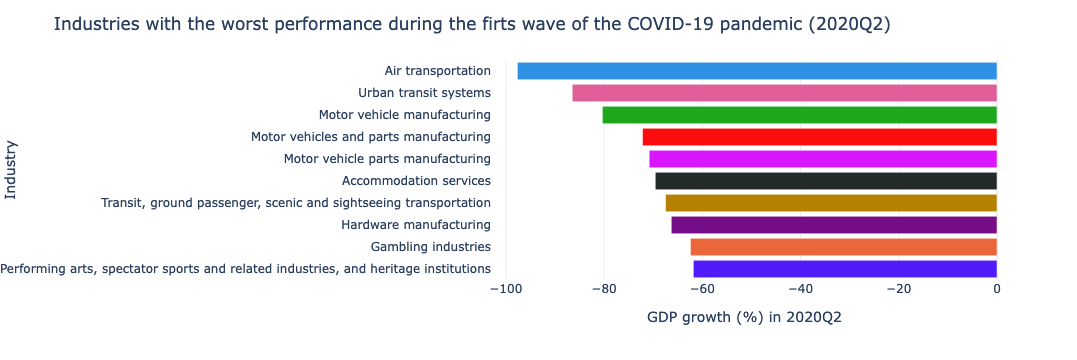

In [30]:
plot_bar_plot(df = worst_industries_gdp_2020, title = 'Industries with the worst performance during the firts wave of the COVID-19 pandemic (2020Q2)', xaxis_title = 'GDP growth (%) in 2020Q2')

☝️ Also not surprisingly, the worst performing industries during 2020Q2 were related to **transporation, travel, and leasure**.

### How have these industries performed since 2020Q2?

👉 A lot of industries have struggled to recover from the COVID-19 pandemic, whereas others that initially performed well have declined since the tech boom in 2020. 

👇 Let's take a look at how the industries with the best and worst performance in 2020 have performed since the end of the COVID-19 pandemic:

In [31]:
best_and_worst_industries_gdp_2020 = pd.concat([best_industries_gdp_2020, worst_industries_gdp_2020], keys = ['best', 'worst']).reset_index(names=['category', 'date'])[['industry', 'industry_code', 'category']]
best_and_worst_industries_gdp = gdp_clean.reset_index(names='date').merge(best_and_worst_industries_gdp_2020, how='inner', on=['industry', 'industry_code']).sort_values(['date', 'category'])
#best_and_worst_industries_gdp = best_and_worst_industries_gdp.groupby(['category', 'date'])['cumulative_growth'].aggregate(['mean', 'std'])
best_and_worst_industries_gdp

date                                           industry industry_code   
34   2019Q2  Banking, monetary authorities and other deposi...          52BX  \
51   2019Q2              Converted paper product manufacturing          3222   
68   2019Q2                            Couriers and messengers           492   
85   2019Q2                                    Crop production           111   
102  2019Q2     Data processing, hosting, and related services           518   
..      ...                                                ...           ...   
220  2023Q2                  Motor vehicle parts manufacturing          3363   
237  2023Q2             Motor vehicles and parts manufacturing          336Y   
271  2023Q2  Performing arts, spectator sports and related ...           71A   
305  2023Q2  Transit, ground passenger, scenic and sightsee...           48Z   
322  2023Q2                              Urban transit systems          4851   

       value  cumulative_growth category  
34   65753.0           0.000000     best  
51    2845.0           0.000000     best  
68    3458.0           0.000000     best  
85   28401.0           0.000000     best  
102   4115.0           0.000000     best  
..       ...                ...      ...  
220  10474.0          11.806149    worst  
237  16689.0          -3.448076    worst  
271   6417.0         -17.667436    worst  
305   7426.0         -22.134843    worst  
322   4404.0         -26.916694    worst  

[340 rows x 6 columns]

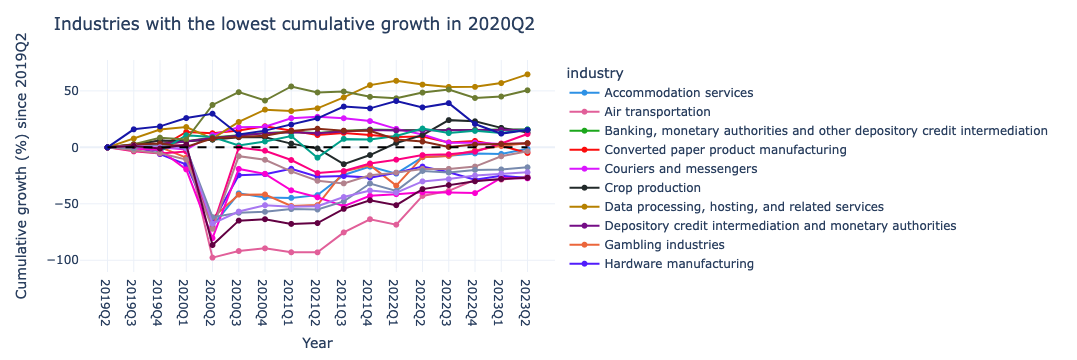

In [32]:
best_and_worst_industries_gdp_2020_list = best_and_worst_industries_gdp_2020['industry_code'].tolist()
plot_line_graph(df = gdp_clean, industry_codes = best_and_worst_industries_gdp_2020_list, y_col = 'cumulative_growth', title = 'Industries with the lowest cumulative growth in 2020Q2', y_axis_title = 'Cumulative growth (%)')

**Overall we can see the following trends:**

1. Both "Data processing, hosting, and related services", and "Non-store retailers" have managed to maintain a good performance since 2019Q2;
2. Some industries such as "Couries and messengers, and "Converted paper product manufacturing" have diminished their growth after a surge during the COVID-19 pandemic;
3. Manufacturing has recovered quite well since the big losses during 2020Q2;
4. Urban transit is still struggling to regain growth since 2020Q2.

### Does the growth of industries with the best/worst performance in 2020Q2 still differ in 2023?

🧐 One way to test if the growth of the industries impacted in 2020 has recovered after the end of the COVID-19 pandemic is to run a statistical comparison between each category and the average across all industries in each time point. 

👉 We have two hypothesis: either the industries show a similar cumulative growth to the average across all industries (null-hypothesis) or they show a significantly different cumulative growth (alternative hypothesis) over time.

✅ First we have to prepare our dataset. We have to separate industries into three categories: those that performed the **best**, the **worst**, and the **average** across industries in 2020Q2.

In [33]:
#The first quarter in our comparison, which is 2020Q2
start_quarter = pd.PeriodIndex([date_range[0]], freq='Q').to_timestamp()

#Gather industries that are not within the best nor the worst datasets
cat_industries_gdp = gdp_clean.query('industry not in @best_and_worst_industries_gdp["industry"]').query('industry not in ["All industries"]').reset_index('date')
cat_industries_gdp['category'] = 'average'

#Then concatenate the average, best, and worst industries together
cat_industries_gdp = pd.concat([cat_industries_gdp, best_and_worst_industries_gdp]).reset_index(drop = True)
cat_industries_gdp['category'] = cat_industries_gdp['category'].astype('category')
cat_industries_gdp

date                                           industry industry_code   
0     2019Q2                   Aboriginal public administration           914  \
1     2019Q2                    Accommodation and food services            72   
2     2019Q2  Accounting, tax preparation, bookkeeping and p...          5412   
3     2019Q2        Activities related to credit intermediation          5223   
4     2019Q2                Administrative and support services           561   
...      ...                                                ...           ...   
4619  2023Q2                  Motor vehicle parts manufacturing          3363   
4620  2023Q2             Motor vehicles and parts manufacturing          336Y   
4621  2023Q2  Performing arts, spectator sports and related ...           71A   
4622  2023Q2  Transit, ground passenger, scenic and sightsee...           48Z   
4623  2023Q2                              Urban transit systems          4851   

        value  cumulative_growth category  
0      4517.0           0.000000  average  
1     43887.0           0.000000  average  
2     12954.0           0.000000  average  
3      3187.0           0.000000  average  
4     45215.0           0.000000  average  
...       ...                ...      ...  
4619  10474.0          11.806149    worst  
4620  16689.0          -3.448076    worst  
4621   6417.0         -17.667436    worst  
4622   7426.0         -22.134843    worst  
4623   4404.0         -26.916694    worst  

[4624 rows x 6 columns]

👇 Let's run multiple t-tests and verify if our hypothesis is rejected (p<0.05):

In [34]:
### Function to define significance level
def p_value_signif(x):
    if x < 0.001:
        return '***'
    elif x < 0.01:
        return '**'
    elif x < 0.05:
        return '*'
    else:
        return 'n.s'
    

### Function to calculate t-test
def t_test_quarters(df, date_column, group_column, groups, control, value_column):
    
    # Initialize lists to store values
    p_values = []
    comparison = []
    quarters_list = []
    
    # Unique quarters
    quarters = df[date_column].unique()
    
    # Length of comparison groups
    len_groups = len(groups)

    # Perform t-test for each quarter
    for quarter in quarters:
        df_quarter = df[df[date_column] == quarter]
        
        # Perform comparison between each group and control
        for i in range(len_groups):
            t_stat, p_value = stats.ttest_ind(df_quarter[df_quarter[group_column] == groups[i]][value_column], 
                                              df_quarter[df_quarter[group_column] == control][value_column], equal_var=False)
            p_values.append(p_value)
            quarters_list.append(quarter)
            comparison.append('-'.join([groups[i], control]))
        
    # Perform multiple test correction
    reject, pvals_corrected, _, _ = multipletests(p_values, method='holm')

    # Create DataFrame with quarters, comparison, and p-values
    quarters = quarters * 3
    p_values_df = pd.DataFrame({
        'quarter': quarters_list,
        'comparison' : comparison,
        'p_value': pvals_corrected
    })
    
    # Apply significance level function
    p_values_df['p_value_signif'] = p_values_df['p_value'].apply(p_value_signif)
    return p_values_df

In [35]:
cat_industries_gdp_ttest = t_test_quarters(df=cat_industries_gdp, date_column='date', group_column='category', groups = ['best', 'worst'], control = 'average', value_column='cumulative_growth')
cat_industries_gdp_ttest

quarter     comparison       p_value p_value_signif
0   2019Q2   best-average           NaN            n.s
1   2019Q2  worst-average           NaN            n.s
2   2019Q3   best-average  2.917339e-01            n.s
3   2019Q3  worst-average  1.000000e+00            n.s
4   2019Q4   best-average  1.638482e-01            n.s
5   2019Q4  worst-average  1.000000e+00            n.s
6   2020Q1   best-average  4.358711e-02              *
7   2020Q1  worst-average  7.997261e-01            n.s
8   2020Q2   best-average  1.327263e-04            ***
9   2020Q2  worst-average  7.713381e-07            ***
10  2020Q3   best-average  8.187044e-03             **
11  2020Q3  worst-average  6.260518e-02            n.s
12  2020Q4   best-average  3.447360e-03             **
13  2020Q4  worst-average  3.667422e-02              *
14  2021Q1   best-average  1.063311e-02              *
15  2021Q1  worst-average  1.055122e-02              *
16  2021Q2   best-average  4.755808e-02              *
17  2021Q2  worst-average  2.547329e-03             **
18  2021Q3   best-average  6.260518e-02            n.s
19  2021Q3  worst-average  2.770224e-03             **
20  2021Q4   best-average  6.260518e-02            n.s
21  2021Q4  worst-average  3.976040e-03             **
22  2022Q1   best-average  6.260518e-02            n.s
23  2022Q1  worst-average  2.505858e-03             **
24  2022Q2   best-average  6.260518e-02            n.s
25  2022Q2  worst-average  7.867950e-03             **
26  2022Q3   best-average  8.845680e-02            n.s
27  2022Q3  worst-average  5.509357e-03             **
28  2022Q4   best-average  6.829864e-02            n.s
29  2022Q4  worst-average  1.164943e-02              *
30  2023Q1   best-average  1.528044e-01            n.s
31  2023Q1  worst-average  3.619622e-02              *
32  2023Q2   best-average  1.836634e-01            n.s
33  2023Q2  worst-average  1.202744e-01            n.s

👇 Great, let's visualize how the cumulative growth of each group has progressed over time and how they deviate from the industry average:

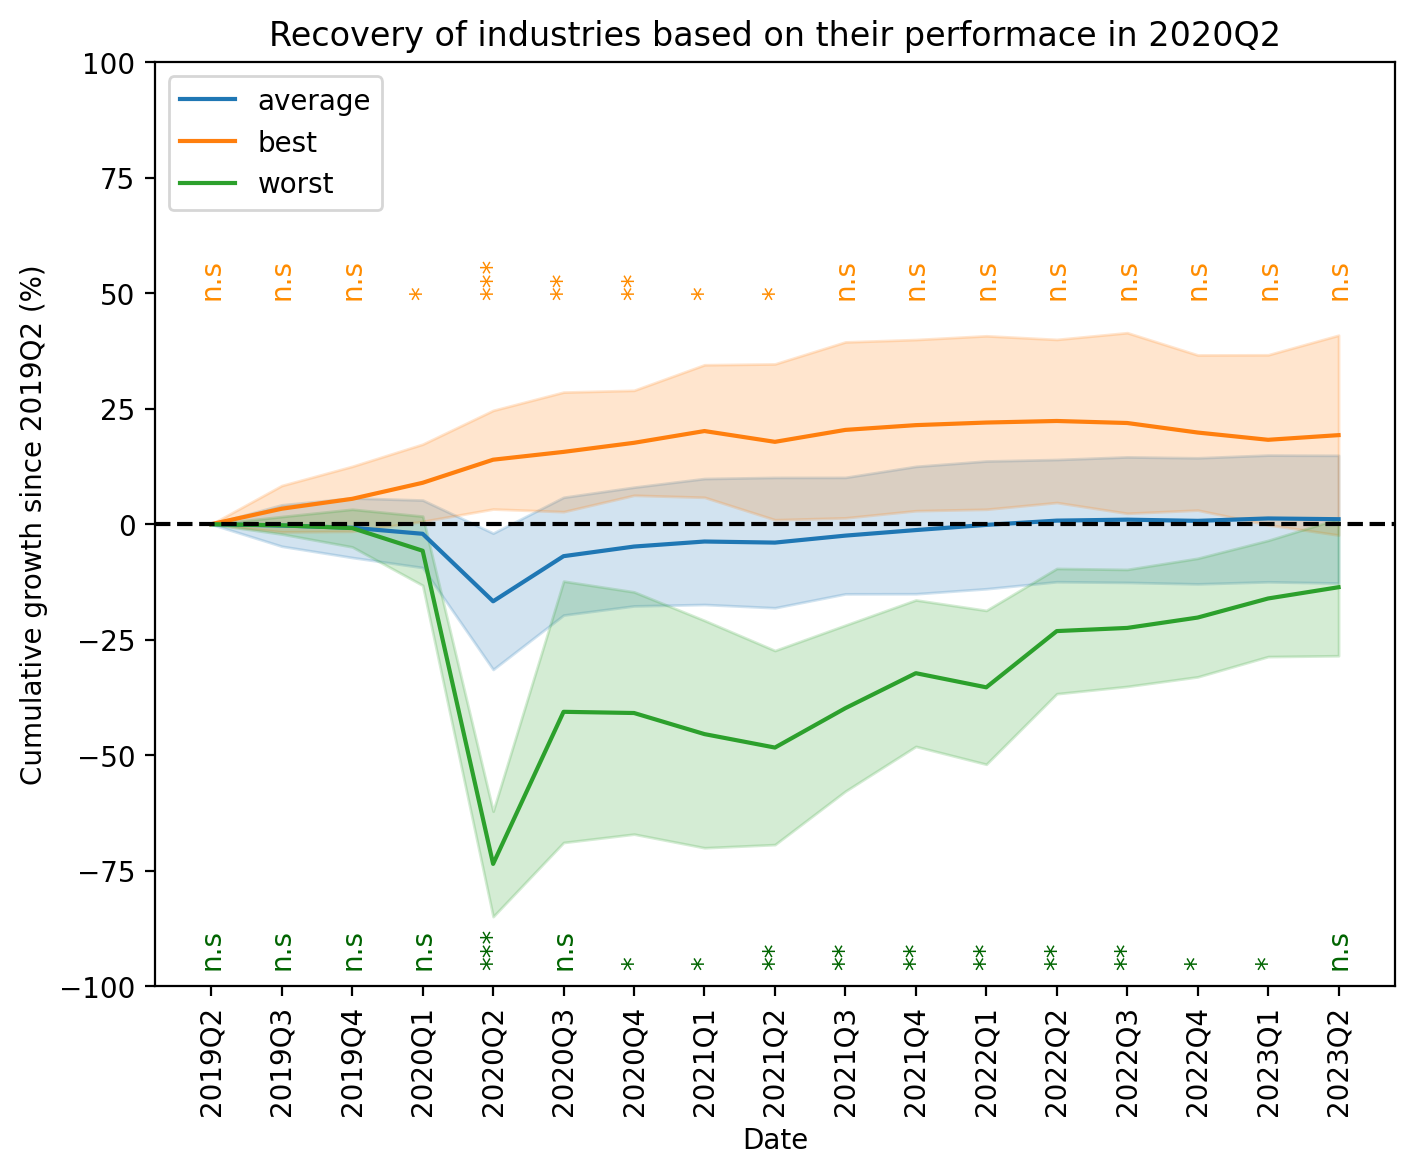

In [36]:
plt.figure(figsize=(8, 6))
sns.lineplot(data = cat_industries_gdp, x = 'date', y = 'cumulative_growth', hue = 'category', errorbar='sd')
plt.xticks(rotation=90)
plt.title('Recovery of industries based on their performace in 2020Q2')
plt.axhline(0, color='black', linestyle='--')
## Add p-value at each timepoint. 
##Green represents the best industries vs. average. Orange represents the worst industries vs. average.
for i in range(len(cat_industries_gdp_ttest['quarter'].unique())):
    plt.text(cat_industries_gdp_ttest.query('comparison == "best-average"')['quarter'].iloc[i], 50, cat_industries_gdp_ttest.query('comparison == "best-average"')['p_value_signif'].iloc[i], rotation=90, color = 'darkorange', horizontalalignment = 'center')
    plt.text(cat_industries_gdp_ttest.query('comparison == "worst-average"')['quarter'].iloc[i], -95, cat_industries_gdp_ttest.query('comparison == "worst-average"')['p_value_signif'].iloc[i], rotation=90, color = 'darkgreen', horizontalalignment = 'center')
plt.legend(loc = 'upper left')
plt.xlabel('Date')
plt.ylabel('Cumulative growth since '+date_range[0]+' (%)')
plt.ylim(-100, 100)
plt.show()

✅ We can clearly see that, after 2020Q2, the industries in the best/worst performance have significantly deviated from the industry average, as expected.

🧐 Interestingly, whereas the growth of the best performing industries have slowly fallen back to the industry average, the growth of the worst performing industries were still struggling until early 2023.

👉 This indicates that the industries most affected by the COVID-19 pandemic have not been able to fully recover just yet, although the trend seems to be getting better in 2023.

## Importing and cleaning an employment dataset

📈 To verify how employment patterns have changed in the last couple of years, we will be using the employment and weekly income by industry dataset from Statistics Canada released on 2023-06-29: 
https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1410022002

In [37]:
employment_earnings = pd.read_csv('/Users/dudi/Dropbox/UofToronto/Project/Portfolio/covid_recovery/data/14100220_employment_earnings_by_industry_weekly.csv', usecols = ['REF_DATE', 'Estimate', 'North American Industry Classification System (NAICS)', 'VALUE'])

🧐 We chose the following columns from this dataset:

**1. REF_DATE:** The month in which the data was collected;

**2. Estimate:** The type of data, either "Employment for all employees" or "Average weekly earnings including overtime for all employees".

**3. North American Industry Classification System (NAICS):** The industry name and NAICS code from which the value was obtained from;

**4. VALUE:** The GDP measure in Canadian dollars (x1,000,000).

In [38]:
employment_earnings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231904 entries, 0 to 231903
Data columns (total 4 columns):
 #   Column                                                 Non-Null Count   Dtype  
---  ------                                                 --------------   -----  
 0   REF_DATE                                               231904 non-null  object 
 1   Estimate                                               231904 non-null  object 
 2   North American Industry Classification System (NAICS)  231904 non-null  object 
 3   VALUE                                                  214765 non-null  float64
dtypes: float64(1), object(3)
memory usage: 7.1+ MB


👉 Once again, we can optimize our dataset by changing the REF_DATE datatype to date/time and NAICS to category.

In [39]:
employment_earnings['REF_DATE'] = pd.to_datetime(employment_earnings['REF_DATE'])
employment_earnings = employment_earnings.astype({'Estimate' : 'category',
          'North American Industry Classification System (NAICS)': 'category'})

In [40]:
employment_earnings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231904 entries, 0 to 231903
Data columns (total 4 columns):
 #   Column                                                 Non-Null Count   Dtype         
---  ------                                                 --------------   -----         
 0   REF_DATE                                               231904 non-null  datetime64[ns]
 1   Estimate                                               231904 non-null  category      
 2   North American Industry Classification System (NAICS)  231904 non-null  category      
 3   VALUE                                                  214765 non-null  float64       
dtypes: category(2), datetime64[ns](1), float64(1)
memory usage: 4.2 MB


👉 Similarly to what we have done before, let's rename our columns:

1. 'REF_DATE' to 'date';
2. 'North American Industry Classification System (NAICS)' to 'industry'
3. 'VALUE' to 'value'
4. 'Estimate' to 'estimate'

👉 Let's also separate the industry code from the industry name and assign it to 'industry_code'.

In [41]:
employment_earnings = employment_earnings.rename(columns = {'REF_DATE' : 'date',
                          'North American Industry Classification System (NAICS)': 'industry',
                          'VALUE' : 'value', 
                            'Estimate' : 'estimate'}).set_index('date')[['industry', 'estimate', 'value']].copy()

new_df = employment_earnings['industry'].str.split('[', expand=True)
employment_earnings['industry'] = new_df[0].str.strip()
employment_earnings['industry_code'] = new_df[1].str.replace(']', '').str.strip()
employment_earnings = employment_earnings[['industry', 'industry_code', 'estimate', 'value']]
employment_earnings = employment_earnings[~employment_earnings['industry'].str.contains('|'.join(['Cannabis', 'cannabis']))].copy()


In [42]:
employment_earnings['estimate'].unique()

['Employment for all employees', 'Average weekly earnings including overtime fo...]
Categories (2, object): ['Average weekly earnings including overtime fo..., 'Employment for all employees']

**We have two types of data in this dataset:**

1. Employment number for all employess per each industry

2. Average weekly earning (including overtime) per each industry

✅ Let's separate them into two distinct datasets: **employment_df** and **income_df**

In [43]:
employment_df = employment_earnings.query('estimate == "Employment for all employees"').drop('estimate', axis=1)
income_df = employment_earnings.query('estimate == "Average weekly earnings including overtime for all employees"').drop('estimate', axis=1)

In [44]:
employment_df

industry industry_code   
date                                                                          
2001-01-01  Industrial aggregate including unclassified bu...        00-91N  \
2001-01-01  Industrial aggregate excluding unclassified bu...        11-91N   
2001-01-01                         Goods producing industries        11-33N   
2001-01-01                      Forestry, logging and support           11N   
2001-01-01                               Forestry and logging           113   
...                                                       ...           ...   
2023-04-01           Federal government public administration           911   
2023-04-01   Provincial and territorial public administration           912   
2023-04-01  Local, municipal and regional public administr...           913   
2023-04-01                   Indigenous public administration           914   
2023-04-01                            Unclassified businesses            00   

                 value  
date                    
2001-01-01  12914390.0  
2001-01-01  12835195.0  
2001-01-01   2910904.0  
2001-01-01     70073.0  
2001-01-01     50650.0  
...                ...  
2023-04-01    262969.0  
2023-04-01    340516.0  
2023-04-01    482325.0  
2023-04-01     69496.0  
2023-04-01    338373.0  

[115416 rows x 3 columns]

## Employment data analysis

📈 Let's take an overall look at the historical employment data from early 2000's to 2023

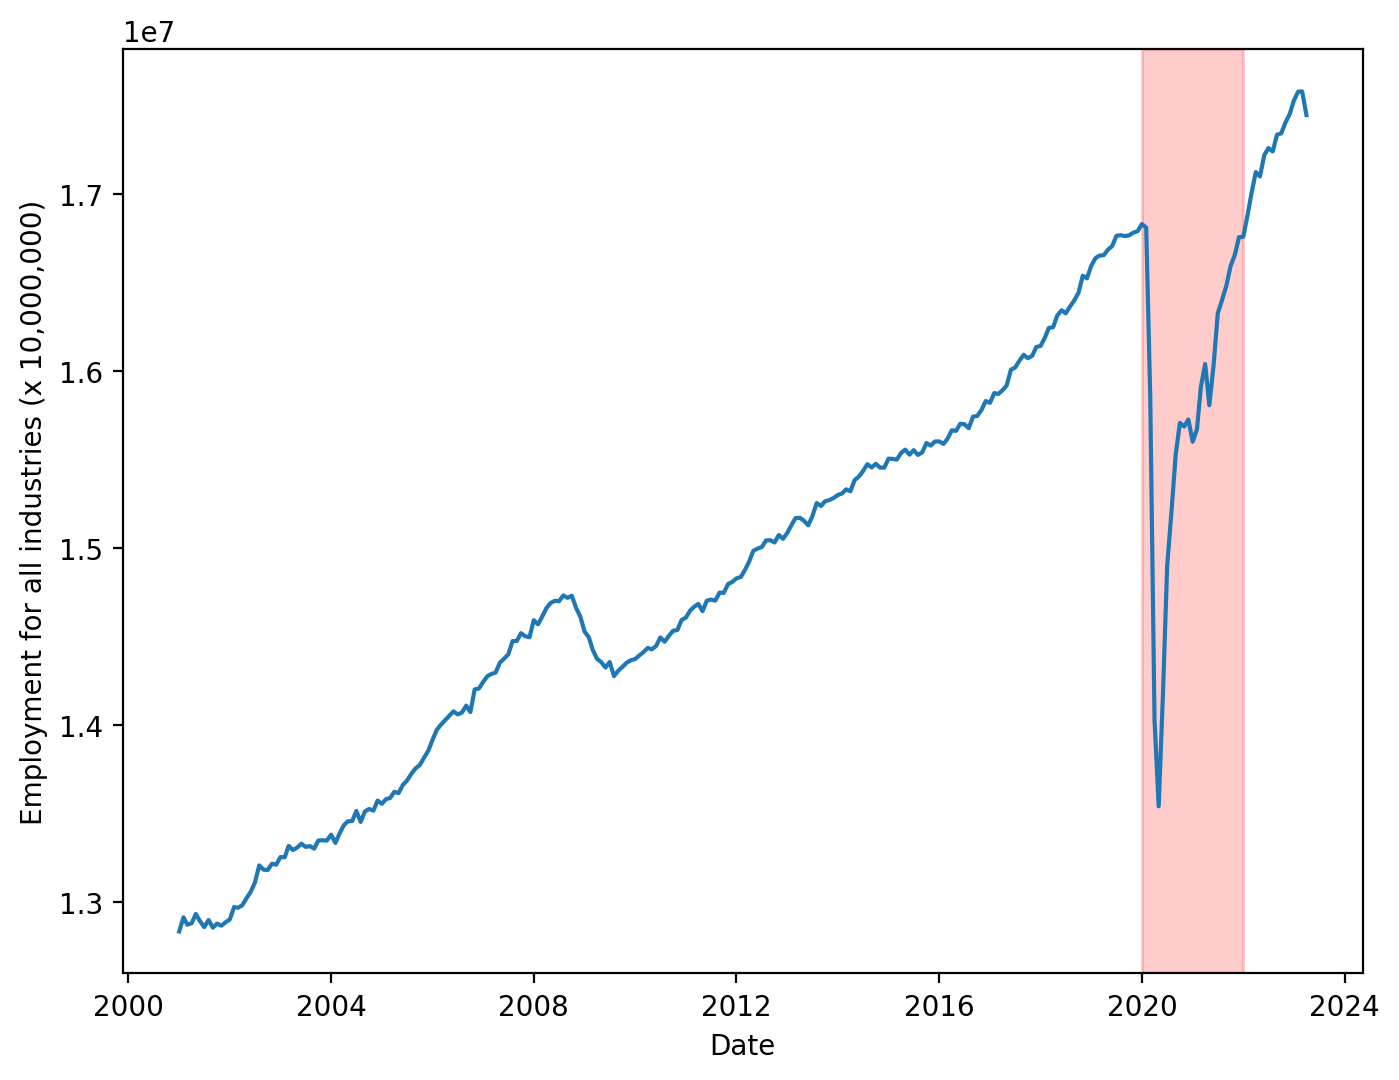

In [45]:
# Create a line plot using Seaborn
plt.figure(figsize=(8, 6))
sns.lineplot(data = employment_df.query('industry == "Industrial aggregate excluding unclassified businesses"'), x = 'date', y = 'value')

# Highlight a section using axvspan() or axhspan()
plt.axvspan('2020-01-01', '2022-01-01', color='red', alpha=0.2)

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Employment for all industries (x 10,000,000)')

# Show the plot
plt.show()

☝️ We can again observe the impact of the COVID-19 pandemic on the employment numbers in the chart above. 

🧐 How has employment numbers recovered for different industries since the end of the pandemic?

👉 Let's first aggregate our data by quarterly periods:

In [46]:
employment_grouped = employment_df.groupby([employment_df.index.to_period('Q'), 'industry', 'industry_code']).median()
employment_grouped

value
date   industry                                           industry_code          
2001Q1 Accommodation and food services                    72             947156.0
       Accommodation services                             721            186626.0
       Accounting, tax preparation, bookkeeping and pa... 5412            65452.0
       Activities related to credit intermediation        5223            12161.0
       Activities related to real estate                  5313            35544.0
...                                                                           ...
2023Q2 Web search portals, libraries and archives, and... 5192            26583.0
       Web search portals, libraries, archives, and al... 519             26583.0
       Wholesale trade                                    41             820614.0
       Wired and wireless telecommunications carriers ... 5173           100164.0
       Wood product manufacturing                         321             94213.0

[38736 rows x 1 columns]

👇 We can use the filter_datarange function from the previous section to filter the dataset and eliminate any time periods and industries with NA's

In [47]:
employment_clean = filter_datarange(df = employment_grouped, date_range = date_range, index_columns = ['industry', 'industry_code'], date_column = 'date', value_column = 'value')
employment_clean

industry industry_code   
date                                                                      
2019Q2                    Accommodation and food services            72  \
2019Q2                             Accommodation services           721   
2019Q2  Accounting, tax preparation, bookkeeping and p...          5412   
2019Q2        Activities related to credit intermediation          5223   
2019Q2                  Activities related to real estate          5313   
...                                                   ...           ...   
2023Q2  Web search portals, libraries and archives, an...          5192   
2023Q2  Web search portals, libraries, archives, and a...           519   
2023Q2                                    Wholesale trade            41   
2023Q2  Wired and wireless telecommunications carriers...          5173   
2023Q2                         Wood product manufacturing           321   

            value  cumulative_growth  
date                                  
2019Q2  1335643.0           0.000000  
2019Q2   203289.0           0.000000  
2019Q2   112364.0           0.000000  
2019Q2    28614.0           0.000000  
2019Q2    61290.0           0.000000  
...           ...                ...  
2023Q2    26583.0          22.282534  
2023Q2    26583.0          22.282534  
2023Q2   820614.0          -0.127911  
2023Q2   100164.0          -4.625697  
2023Q2    94213.0          -1.838963  

[6341 rows x 4 columns]

### Which industries have gained the most jobs since 2019Q2?

🧐 Let's check which industries have accumulated the highest employment growth since 2019Q2

In [48]:
best_industries_employment = employment_clean.xs(date_range[1]).nlargest(n = 10, columns = 'cumulative_growth')
best_industries_employment

industry industry_code   
date                                                                      
2023Q2  Resin, synthetic rubber, and artificial and sy...          3252  \
2023Q2         Support activities for rail transportation          4882   
2023Q2  Computing infrastructure providers, data proce...      518,5182   
2023Q2  Mineral, ore and precious metal merchant whole...          4185   
2023Q2       Computer systems design and related services          5415   
2023Q2                Local messengers and local delivery          4922   
2023Q2  Community food and housing, and emergency and ...          6242   
2023Q2                  Household appliance manufacturing          3352   
2023Q2       Scientific research and development services          5417   
2023Q2               Railroad rolling stock manufacturing          3365   

           value  cumulative_growth  
date                                 
2023Q2    7521.0          68.405732  
2023Q2    6375.0          64.516129  
2023Q2   31807.0          57.538385  
2023Q2     835.0          55.204461  
2023Q2  387582.0          50.284414  
2023Q2   12111.0          49.334155  
2023Q2   23966.0          47.093844  
2023Q2    2542.0          44.267877  
2023Q2   73553.0          41.854545  
2023Q2    6157.0          41.280404

🧐🧐 And which one of these industries have also accumulated the highest growth since 2019Q2?

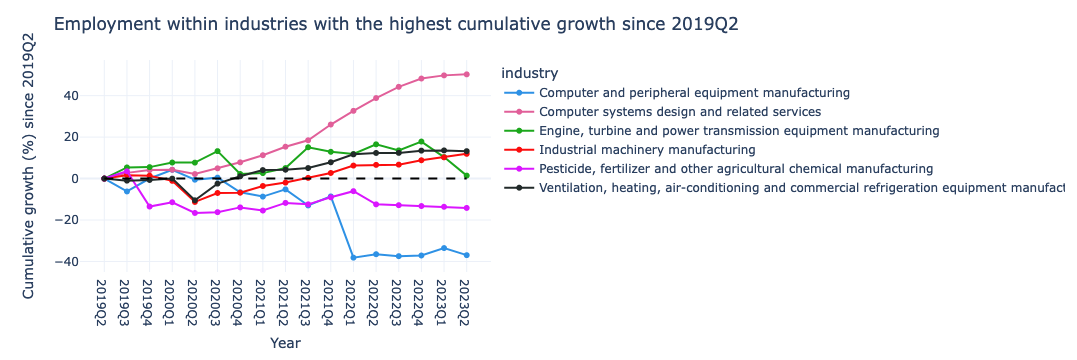

In [49]:
plot_line_graph(df = employment_clean, industry_codes = best_industries_gdp_list, y_col = 'cumulative_growth', title = ''.join(['Employment within industries with the highest cumulative growth since ', date_range[0]]), y_axis_title = 'Cumulative growth (%)')

📈 Nice! We can clearly see, once again, that industries related to computer system designs and related services have had an enourmous growth since 2019!

## Salary income analysis

👌 So far we have seen that data- and computer-related industries have grown massively since the COVID-19 pandemic. 

💰 Have salaries followed suit? Let's take a look!

In [50]:
income_df

industry industry_code   
date                                                                          
2001-01-01  Industrial aggregate including unclassified bu...        00-91N  \
2001-01-01  Industrial aggregate excluding unclassified bu...        11-91N   
2001-01-01                         Goods producing industries        11-33N   
2001-01-01                      Forestry, logging and support           11N   
2001-01-01                               Forestry and logging           113   
...                                                       ...           ...   
2023-04-01           Federal government public administration           911   
2023-04-01   Provincial and territorial public administration           912   
2023-04-01  Local, municipal and regional public administr...           913   
2023-04-01                   Indigenous public administration           914   
2023-04-01                            Unclassified businesses            00   

              value  
date                 
2001-01-01      NaN  
2001-01-01   657.36  
2001-01-01   819.81  
2001-01-01   769.99  
2001-01-01   776.20  
...             ...  
2023-04-01  1897.02  
2023-04-01  1608.10  
2023-04-01  1358.40  
2023-04-01   987.87  
2023-04-01      NaN  

[115416 rows x 3 columns]

👇 First let's take a look at the average weekly income across all industries (in CAD dollars):

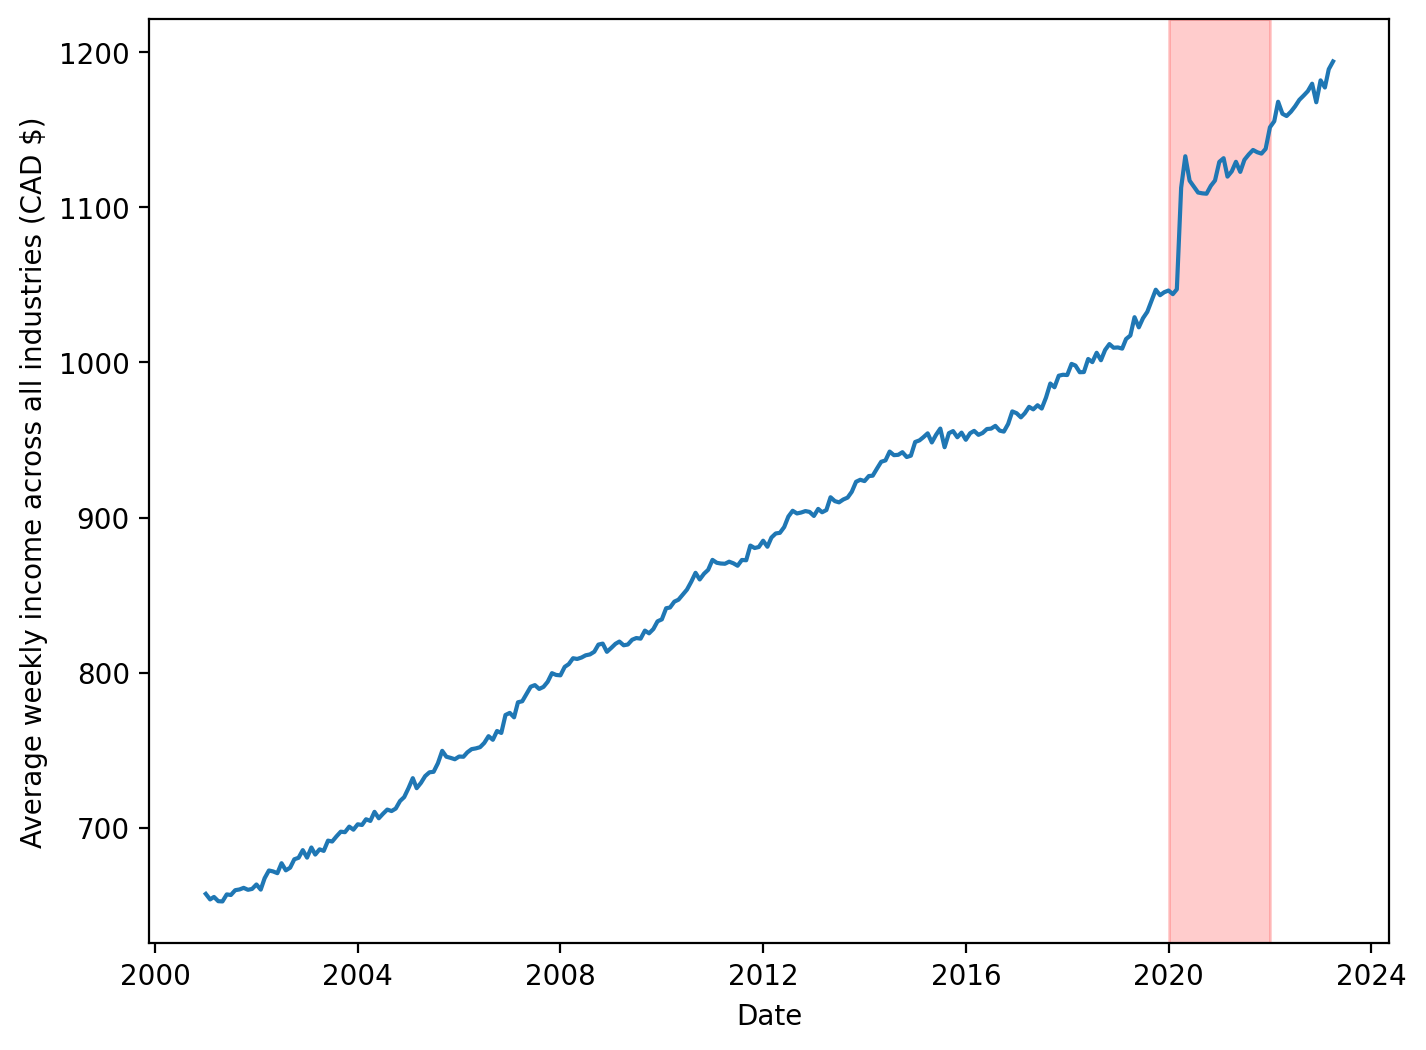

In [51]:
# Create a line plot using Seaborn
plt.figure(figsize=(8, 6))
sns.lineplot(data = income_df.query('industry == "Industrial aggregate excluding unclassified businesses"'), x = 'date', y = 'value')

# Highlight a section using axvspan() or axhspan()
plt.axvspan('2020-01-01', '2022-01-01', color='red', alpha=0.2)

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Average weekly income across all industries (CAD $)')

# Show the plot
plt.show()

📈 Interestingly, the average weekly salary across all industries has gone up during the COVID-19 pandemic.

🧐 Which industries have grown their weekly salary the most?

In [52]:
#Calculate the median in each quarter
income_grouped = income_df.groupby([income_df.index.to_period('Q'), 'industry', 'industry_code']).median()
#Filter results between 2019Q2 and 2023Q2
income_clean = filter_datarange(df = income_grouped, date_range = date_range, index_columns = ['industry', 'industry_code'], date_column = 'date', value_column = 'value')
#Gather the top 10 industries with 
best_industries_income = income_clean.xs(date_range[1]).nlargest(n = 10, columns = 'value').sort_values('cumulative_growth', ascending=False)
best_industries_income

industry industry_code   
date                                                                      
2023Q2   Steel product manufacturing from purchased steel          3312  \
2023Q2     Alumina and aluminum production and processing          3313   
2023Q2  Non-ferrous metal (except aluminum) production...          3314   
2023Q2  Computing infrastructure providers, data proce...      518,5182   
2023Q2                                Software publishers          5132   
2023Q2  Electric power generation, transmission and di...          2211   
2023Q2      Mining, quarrying, and oil and gas extraction            21   
2023Q2                             Oil and gas extraction      211,2111   
2023Q2          Mining and quarrying (except oil and gas)           212   
2023Q2                                   Metal ore mining          2122   

          value  cumulative_growth  
date                                
2023Q2  2235.86          65.521173  
2023Q2  2153.54          52.159229  
2023Q2  2426.11          35.451363  
2023Q2  2216.21          26.474348  
2023Q2  2269.17          19.054040  
2023Q2  2197.34          13.580515  
2023Q2  2332.81           8.296272  
2023Q2  2807.41           3.847377  
2023Q2  2193.31           3.002282  
2023Q2  2285.84           0.999907

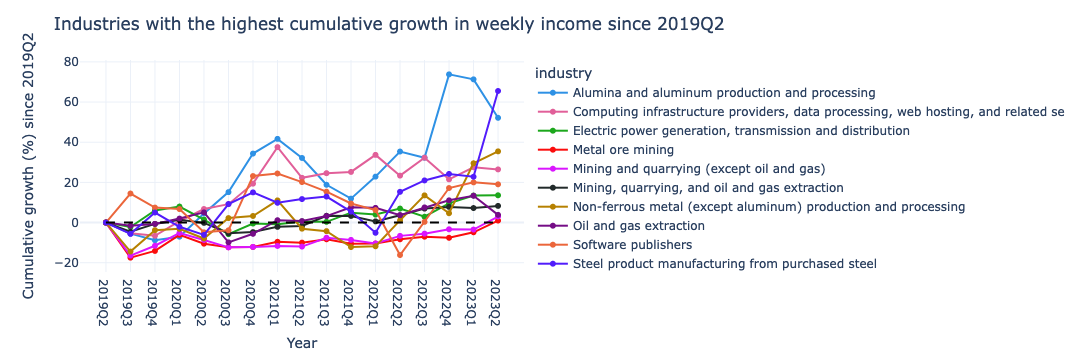

In [53]:
best_industries_income_list = best_industries_income['industry_code'].to_list()
plot_line_graph(df = income_clean, industry_codes = best_industries_income_list, y_col = 'cumulative_growth', title = ''.join(['Industries with the highest cumulative growth in weekly income since ', date_range[0]]), y_axis_title = 'Cumulative growth (%)')

✅ Following a similar trend as before, we see that the "Computing infrastructure providers, data processing, web hosting, and related services" industry is among the top 10 industries with the highest weekly salary gains since 2019Q2.

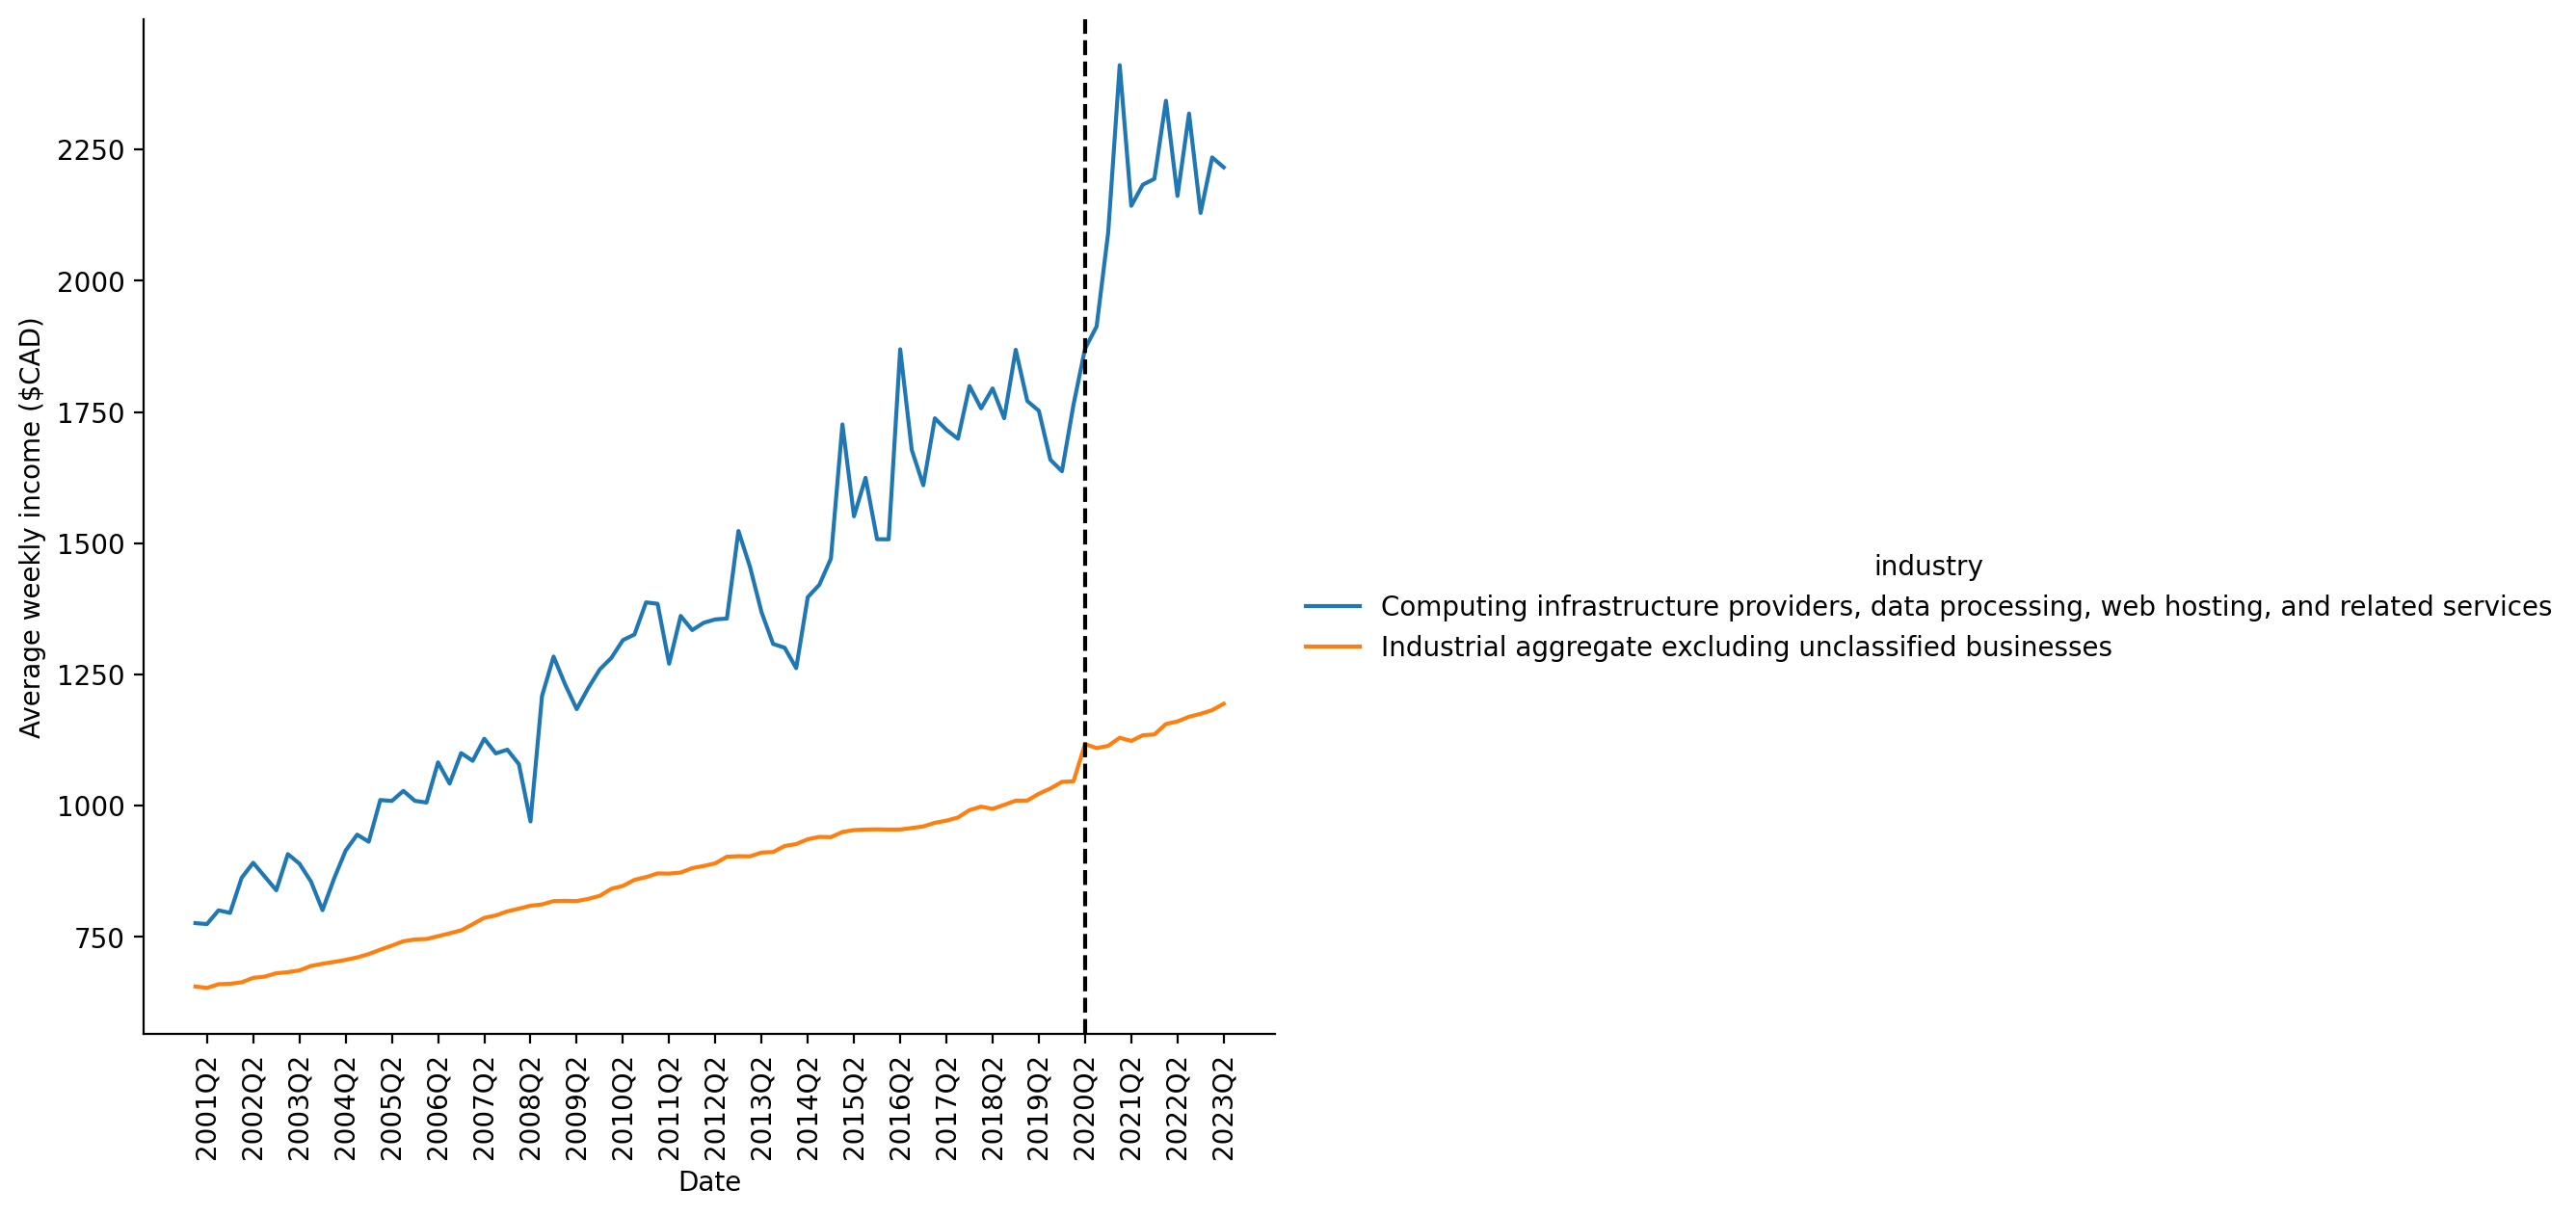

In [54]:
income_subset_list = ["Computing infrastructure providers, data processing, web hosting, and related services", "Industrial aggregate excluding unclassified businesses"]
income_subset = income_grouped.query('industry in @income_subset_list').reset_index(col_level = 0)
income_subset['date'] = income_subset['date'].astype('str')
sns.relplot(income_subset, x = 'date', y = 'value', kind = 'line', hue = 'industry', height=6, aspect=1.25)
plt.xticks(income_subset[income_subset['date'].str.contains('Q2')]['date'].unique().tolist())
plt.axvline('2020Q2', color='black', linestyle='--')
plt.xticks(rotation=90)
# Set labels and title
plt.xlabel('Date')
plt.ylabel('Average weekly income ($CAD)')
plt.show()

🤓 In fact, we can see the massive jump in average weekly income for "Computing infrastructure providers, data processing, web hosting, and related services" starting in 2020Q2!

## Conclusion

👉 Different industries have shown distinct growth trajectories in the aftermath of the COVID-19 pandemic.

👉 Online and data-related companies have notably outperformed other sectors since 2020, marking a shift towards digital reliance in the economy.

👉 Traditional sectors such as manufacturing, transport, and leisure bore significant negative impacts from the pandemic in 2020.

👉 Despite their initial robust growth during the pandemic, online and data-centric industries are experiencing a slowdown in their growth rate when compared to the broader industry average.

👉 Conversely, the worst-hit sectors during the pandemic, including manufacturing, transport, and leisure, are still struggling to achieve full recovery.

👉 The computer-related industry has seen a significant surge in job growth since 2020, signifying an increasing demand for tech skills in the economy.

👉 Reflecting a similar trend, the computer and data-related sectors have demonstrated considerable salary growth in recent years, underscoring their rising importance in the economy.